# From the Small Capitalist to the Corporate Elite: Who owns and controls the means of production?

**Abstract:** We generate Big, Open datasets related to company officer-ship and control, and use a variety of algorithms to engineer new features, providing a range of advancements related to stratification, diveristy and corporate governance. Our approach allows a consideration beyond the traditionally studied 'Corporate Elite', utilizing data across all sub-strata of officers and owners (such as the petite borgeousie and 'small capitalists') across all Standard Industry Classifiers. We integrate and advance existing gender inference algorithms, geospatial methods, techniques to parse electronic accounts, and computationally efficient network approximations, applying them to a typically advanced, late capitalist economy which leads the world in terms of Open Data (the United Kingdom). Our applications incorporate auxillery data (such as indices of deprivation and shapefiles), focusing on variables of classical interest integral to the study of social stratification with respect to distributions across gender, age, nationality, occupation and spatial segregation. We also provide new results related to board overlap, the rise of the service economy, and the business case for diversity.

## 1. Preamble

Lets first load all the gizmos we're going to need for analysis:

In [21]:
from ch_supportfunctions import (
    gender_by_row,
    make_gender,
    make_age,
    gender_by_row,
    evaluate_nationality_merge,
    send_df_to_clean_for_nat,
    make_timely_gender,
    add_datetimes,
    call_namsor_api,
    make_edgelist,
    drop_dupes,
    bus_div_reg,
    millions,
    evaluate_clean_dfs,
    only_active)

from ch_generate_toplot import (
    gen_desc_toplot,
    gen_gen_toplot,
    gen_age_toplot,
    gen_nat_toplot,
    gen_res_toplot,
    gen_reg_toplot,
    gen_net_toplot)
    
from ch_engineer_features import (
    engineer_gender,
    engineer_residences,
    engineer_nat,
    engineer_age)

from ch_load_data import (
    load_nat,
    load_token,
    load_raw_data,
    load_engineered_data,
    load_regional,
    sicmaker)

from ch_generate_flat import (
    generate_psc_flat,
    generate_officer_flat,
    originate_psc,
    ch_generate_regdf,
    generate_accounts,
    originate_basic)

import pandas as pd
from tqdm import tqdm
from urllib.parse import urljoin
import warnings
import os
import csv
import scipy
import numpy as np
import geopandas as gpd
import requests
import glob
from itertools import islice
import gzip
import io
import json
#from networkit import *
#import networkit

import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

sns.set_context("notebook", font_scale=1)
sns.set_style("ticks")
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['axes.edgecolor'] = 'k'
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then lets define some key paths and filenames as variables to make our life easier:

In [22]:
CH_Data = os.path.abspath(os.path.join('__file__',
                                       '../../..', 'CH_Data'))
Local_Data = os.path.abspath(os.path.join('__file__',
                                          '../..', 'data'))
Figures = os.path.abspath(os.path.join('__file__',
                                       '../..', 'figures'))
Tables = os.path.abspath(os.path.join('__file__',
                                      '../..', 'tables'))
Regional = os.path.abspath(os.path.join('__file__',
                                        '../..', 'data',
                                        'regional'))
nat_path = os.path.join(Local_Data, 'nationalities')

basic_filename = 'BasicCompanyDataAsOneFile-2019-01-01'
psc_filename = 'persons-with-significant-control-snapshot-2019-01-24'

ch_url = 'http://download.companieshouse.gov.uk/'

## 2. Data Origination

Lets first check that we have the latest data:

### 2.1 PSC

Freezing data for now at January 2019 with comments

In [3]:
#originate_psc(ch_url, psc_filename, CH_Data)

### 2.2 Basic Data

In [4]:
originate_basic(ch_url, basic_filename, CH_Data)

### 2.3 Officer Data

In [5]:
#APIKey = load_token(os.path.abspath(os.path.join('__file__', '../..', 'ch_apikey')))
#generate_officer_flat(APIKey,
#                      os.path.join(CH_Data,
#                                   'ch_full_officers.tsv')),
#                      os.path.join(CH_Data,
#                                   basic_filename + '.csv'))

### 2.4 Load Raw Flat Files (obtained above)

In [6]:
ch_basic, ch_psc, ch_off = load_raw_data(os.path.join(CH_Data,
                                                      basic_filename + 
                                                      'csv.gz'),
                                         os.path.join(CH_Data,
                                                      'psc_flatfile.tsv.gz'),
                                         os.path.join(CH_Data,
                                                      'ch_full_officers.tsv.gz'))
print('Length of ch_off: ' + str(len(ch_off)) + '.\n' + 
      'Length of ch_psc: ' + str(len(ch_psc)) + '.')

Length of ch_off: 17172800.
Length of ch_psc: 6467061.


### 2.5 Accounts Data

Lets build in the parsed accounts data here. Run ```ch_get_and_parse_accounts.py``` seperately to make sure that all the relevant files are in the right place:

In [7]:
generate_accounts(CH_Data, Local_Data, ch_basic)

Now lets load in each of these raw files into our workspace, and begin to clean and engineer them:

## 3. Load Supplementary Datasets

Now lets load in all of the auxillery datasets (which are not for companies house) which are used for analysis

### 3.1 Load nationality data

These are our manually curated dictionaries for cleaning nationalities:

In [23]:
anom_remove, anom_replace, un_states, ons_df = load_nat(nat_path)

### 3.2 Load Regional Data

These files are required for cleaning and mapping the residences data:

In [24]:
postcodes, map_london_df, map_uk_df, dist_to_nuts = load_regional(Regional)

## 4. Clean and Engineer

### 4.1 Clean Dataframes

First clean for a number of hard drops which filters out rows of the dataframes we want to permanently exclude, and add in a new field (.dt fields)

#### 4.1.1 Clean for only companies in ch_basic

This is a 'hard' drop: only include fields which are in the current CH basic file. For 'soft' drops (i.e. filters on the dataframe), we dont drop fields with nulls, nans or anonomlous values permanently.

In [10]:
ch_off, ch_psc = only_active(ch_off, ch_psc, ch_basic)

We drop 802233 rows of PSC data which is not in the ch_basic flatfile (12.404908504806125%).
We drop 789691 rows of Officer data which is not in the ch_basic flatfile (4.59849878878226%).
Length of ch_off: 16383109.
Length of ch_psc: 5664828.


#### 4.1.2 Clean duplicate Officers and PSC

In [11]:
ch_off, ch_psc = drop_dupes(ch_off, ch_psc)

We drop 182187 potentially duplicate officers (1.112%).
We drop 51499 potentially duplicate PSC (0.909%).


#### 4.1.3 Add .dt fields to the appointed and resigned fields

In [12]:
ch_off = add_datetimes(ch_off)

Converting 'Resigned' strings to datetime!: 100%|██████████| 11517/11517 [00:00<00:00, 25017.08it/s]


### 4.2 Clean\Engineer for Gender

##### 4.2.1 Engineering

In [13]:
ch_off, ch_psc, sic_timely_off_gender, timely_df_a_gender = engineer_gender(ch_off, ch_psc, ch_basic)

100%|██████████| 27/27 [19:32<00:00, 66.55s/it]


We observe 13188429 rows of Officer data which cannot be determined as m/f (81.40542248151063%).
We observe 4680605 rows of PSC data which cannot be determined as m/f (83.38376389482961%).
Length of ch_off: 16200922.
Length of ch_psc: 5613329.


#### 4.2.2 Unit Tests

In [14]:
psc_titleandfore = ch_psc[(ch_psc['isfemale']==1.0) |
                          (ch_psc['isfemale']==0.0)][['forename','title']]
psc_fore = ch_psc[(ch_psc['isfemale']==1.0) |
                  (ch_psc['isfemale']==0.0)][['forename']]
tqdm.pandas(desc="Unit test: gender of PSC with titles and forenames!")
psc_titleandfore.loc[:, 'gender'] = psc_titleandfore.progress_apply(gender_by_row,
                                                                    axis=1)

tqdm.pandas(desc="Unit test: gender of PSC with NamSor API!")    
psc_name = ch_psc[(ch_psc['isfemale']==1.0) |
                  (ch_psc['isfemale']==0.0)][['name', 'forename']]
psc_name = psc_name.drop_duplicates(subset=['forename'])[0:1000]
psc_name['gender'] = psc_name.progress_apply(call_namsor_api, axis=1)
tqdm.pandas(desc="Unit test: gender of PSC with forenames alone!")
psc_fore.loc[:, 'gender'] = psc_fore.progress_apply(gender_by_row, axis=1)
print('Title and Forenames vs Forenames alone return the same value ' + 
      str(round((pd.value_counts(psc_fore['gender']==psc_titleandfore['gender'].values,
                 sort=False)[1]/len(psc_fore))*100,2)) + 
      '% of the time.')
print('Title and Forenames vs NamSor API return the same value ' + 
      str(round((pd.value_counts(psc_name['gender']==psc_titleandfore.\
                                 drop_duplicates(subset=['forename'])[0:1000]['gender'].\
                                 values,
                 sort=False)[1]/len(psc_name))*100,2)) + 
      '% of the time.')
print('Forenames alone vs NamSor API return the same value ' + 
      str(round((pd.value_counts(psc_name['gender']==psc_fore.\
                                 drop_duplicates(subset=['forename'])[0:1000]['gender'].\
                                 values,
                 sort=False)[1]/len(psc_name))*100,2)) + 
      '% of the time.')

Unit test: calculating gender of PSC with titles and forenames!: 100%|██████████| 4680605/4680605 [01:45<00:00, 44334.35it/s]
Unit test: calculating gender of PSC with NamSor API!: 100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]
Unit test: calculating gender of PSC with forenames alone!: 100%|██████████| 4680605/4680605 [02:03<00:00, 37805.15it/s]


Title and Forenames vs Forenames alone return the same value 88.97% of the time.
Title and Forenames vs NamSor API return the same value 91.9% of the time.
Forenames alone vs NamSor API return the same value 75.0% of the time.


### 4.3 Clean\Engineer for Age

In [15]:
ch_off, ch_psc = engineer_age(ch_off, ch_psc)

We observe 4413547 rows of Officer data which have null age (27.242566811938236%).
We observe 848253 rows of PSC data which have null age (15.111407152511461%).
Length of ch_off: 16200922.
Length of ch_psc: 5613329.


### 4.4 Clean\Engineer for Residences

In [16]:
ch_off, ch_psc = engineer_residences(ch_off, ch_psc, dist_to_nuts, postcodes)

We observe 624232 rows of PSC data which are not successfully  mapped to districts (11.120531150053738%).
We observe 937471 rows of Officer data which are not successfully mapped to districts (5.786528692626259%).
We observe 0 rows of PSC data which are not successfully mapped to postcodes (0.0%).
We observe 0 rows of Officer data which are not successfully mapped to postcodes (0.0%).
Length of ch_off: 16200922.
Length of ch_psc: 5613329.


### 4.5 Clean\Engineer for Nationalities

In [17]:
ch_off, ch_psc = engineer_nat(ch_off, ch_psc, anom_remove, anom_replace)
evaluate_nationality_merge(ch_off, un_states)
evaluate_nationality_merge(ch_psc, un_states)

Cleaning nationalities...: 100%|██████████| 2741/2741 [00:02<00:00, 989.97it/s] 


We observe 0 rows of Officer data which are not successfully mapped to Nationalities (0.0%).
We observe 0 rows of Officer data which are not successfully mapped to Nationalities (0.0%).
Length of ch_off: 16200922.
Length of ch_psc: 5613329.
In total, we see: 212 unique UN Member States, Overseas Territories or countries as yet unrecognised.

There are a total of 193 UN Member States and we see 191 of them.

The UN Member states that we dont observe are: Federated States of Micronesia, Palau

The non-UN Member states that we do observe are: Kosovo, Palestine, Bermuda, N\An, Cayman Islands, Gibraltar, Isle Of Man, Puerto Rico, Guernsey, Cook Islands, Vanatu, Channel Islands, Falkland Islands, Montserrat, Guam, Saint Helena, Tasmania, Sint Maarten, Guadeloupe, Vatican, Tahiti. Might need to add some new looking entries to the list and dict.
In total, we see: 198 unique UN Member States, Overseas Territories or countries as yet unrecognised.

There are a total of 193 UN Member States and w

### 4.7 Save engineered datasets for faster loading later on

In [18]:
sic_timely_off_gender.to_csv(os.path.join(Local_Data,
                                          'timely',
                                          'sic_timely_off_gender.tsv.gz'),
                             compression = 'gzip', sep='\t')
timely_df_a_gender.to_csv(os.path.join(Local_Data, 'timely',
                                       'timely_df_a_gender.tsv.gz'),
                          compression = 'gzip', sep='\t')
ch_psc.to_csv(os.path.join(Local_Data, 'engineered',
                           'ch_psc.tsv.gz'),
              compression = 'gzip', index=False, sep='\t')
ch_off.to_csv(os.path.join(Local_Data, 'engineered',
                           'ch_off.tsv.gz'),
              compression = 'gzip', index=False, sep='\t')

## 5. Load in engineered datasets

If we're running the dataset without generating new data, run from here.

The only dependancies for this part onwards are cells [1] and [2].

In [25]:
sic_timely_off_gender = pd.read_csv(os.path.join(Local_Data,
                                                 'timely',
                                                 'sic_timely_off_gender.tsv.gz'),
                                                 compression = 'gzip',
                                                 index_col=0,
                                                 sep='\t')
timely_df_a_gender = pd.read_csv(os.path.join(Local_Data,
                                              'timely',
                                              'timely_df_a_gender.tsv.gz'),
                                              compression = 'gzip',
                                              sep='\t')
timely_df_a_gender.set_index('Unnamed: 0', inplace=True)
ch_psc, ch_off, ch_accounts = load_engineered_data(os.path.join(Local_Data,
                                                                'engineered',
                                                                'ch_psc.tsv.gz'),
                                                   os.path.join(Local_Data,
                                                                'engineered',
                                                                'ch_off.tsv.gz'),
                                                   os.path.join(Local_Data,
                                                                'engineered',
                                                                'ch_accounts_2017.csv.gz'))
ch_basic = pd.read_csv(os.path.join(CH_Data,
                                    basic_filename + '.csv.gz'),
                       encoding='latin-1', sep=',',
                       error_bad_lines=False,
                       warn_bad_lines=False,
                       dtype={' CompanyNumber': str,
                              'SICCode.SicText_1': str,
                              'IncorporationDate': str},
                       usecols=[' CompanyNumber',
                                'SICCode.SicText_1',
                                'IncorporationDate'])

## 6. Company Descriptives

Begin a section on some pure descriptives of the dataset in terms of high level patterns and network analysis of board overlap.

### 6.1 Network Analysis

This relies heavily on NetworKit: check your installation!

First create a (better) filter for unique officers: The 'Officer ID' field is very poor for expected reasons... (people don't chain themselves properly when logging into the portal).

In [20]:
ch_off['New_ID'] = ch_off['Name'] + '@ ' +\
                   ch_off['Age'].astype(str)

New_ID   Size
7515844  SWIFT INCORPORATIONS LIMITED@ nan@ N\A  75157
7623049    TEMPLE SECRETARIES LIMITED@ nan@ N\A  50889
1587220     COMPANY DIRECTORS LIMITED@ nan@ N\A  49210
2588407      FORM 10 DIRECTORS FD LTD@ nan@ N\A  38875
2588410    FORM 10 SECRETARIES FD LTD@ nan@ N\A  37569

#### 6.1.1 Tabulating most seen people and companies on the register

Simple groupbys to see who's doing what most frequently...:

In [ ]:
ch_off.groupby(['New_ID']).size()\
                          .reset_index(name='Size')\
                          .sort_values(by='Size',
                                       ascending=False)[0:5]

In [21]:
ch_off[(ch_off['isfemale']==1.0) |
       (ch_off['isfemale']==1.0)].groupby(['New_ID']).size()\
                          .reset_index(name='Size')\
                          .sort_values(by='Size',
                                       ascending=False)[0:5]

New_ID   Size
1281911  KAHAN, Barbara@ 87.77409665432901@ UK  24637
928756           GRAEME, Dorothy May@ nan@ N\A   6182
1032841       HARRISON, Irene Lesley@ nan@ N\A   4790
286822               BREWER, Suzanne@ nan@ N\A   4618
1285179            KANE, Dorothy May@ nan@ N\A   3260

#### 6.1.2 Build and summarize the edges here

Note: we're filtering for officers only active for entireity of 2017 (which is a function input).

In [22]:
edge_set, company_set, officer_set  = make_edgelist(ch_off,
                                                    2017,
                                                    os.path.join(Local_Data,
                                                                 'edges',
                                                                 'edgelist.txt'))

count                                             New_ID                            Name
 1797      VARON, Alona@ 37.100913768985706@ Philippines                    VARON, Alona
 1517         BATES, David Leslie@ 56.69063840398847@ UK             BATES, David Leslie
 1500           DAY, Julia Rachel@ 27.77286459617586@ UK               DAY, Julia Rachel
 1488         WHITFIELD, Lucy Ann@ 26.68865342140841@ UK             WHITFIELD, Lucy Ann
 1200     GLEISSNER, Michael@ 49.93895972475482@ Germany              GLEISSNER, Michael
 1031         PERKINS, Mary Lesley@ 75.1030630259862@ UK            PERKINS, Mary Lesley
 1001  EVANS, Jeremy  Richard Holt@ 60.85773286862497...     EVANS, Jeremy  Richard Holt
  743     VALAITIS, Peter Anthony@ 68.35412225375951@ UK         VALAITIS, Peter Anthony
  727           SAPHIRE BLUE DIRECTORS LIMITED@ nan@ N\A  SAPHIRE BLUE DIRECTORS LIMITED
  684               FELDMAN, Marc@ 57.27107468947004@ UK                   FELDMAN, Marc


100%|██████████| 12843204/12843204 [00:07<00:00, 1736764.32it/s]


Summarize the data used to build the edgelist:

In [23]:
print('Number officers (active entire 2017) sitting on multiple boards: ' +
      str(len(officer_set)) + '.')
print('Number of companies enjoying a board overlap: ' +
      str(len(company_set)) + '.')
print('Number of edges in our dataset: ' +
     str(len(edge_set)) + '.')

Number of officers (active for whole 2017) sitting on multiple boards: 3574700.
Number of companies enjoying a board overlap: 1333049.
Number of edges in our dataset: 12843204.


#### 6.1.3 Analysis on all Components

First calculate the entire entwork (all components), and summarize it:

In [27]:
nodeData = pd.read_csv(os.path.join(Local_Data,
                                   'edges',
                                   'edgelist.txt'),
                      sep=';',names=['edge1','edge2'])
nodeData = pd.DataFrame(list(set(nodeData['edge1'].tolist() +
                                nodeData['edge2'].tolist()))).rename({0:'node'},
                                                                    axis=1)
nodeIds = {row[1].node:row[0] for row in nodeData.iterrows()}
Entire = networkit.graph.Graph(len(nodeData))
with open(os.path.join(Local_Data, 'edges', 'edgelist.txt')) as f:
    for line in tqdm(f):
        if not line.startswith('#') and line.strip():
            splitLine = line.strip().split(";")
            sourceId = nodeIds.get(splitLine[0], None)
            targetId = nodeIds.get(splitLine[1], None)
            if sourceId != None and targetId != None:
                Entire.addEdge(sourceId, targetId)
overview(Entire)

12843204it [00:30, 415230.26it/s]


Network Properties for:		G#3
nodes, edges			1332549, 12843204
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.000014
clustering coefficient		0.558868
min/max/avg degree		1, 1796, 19.276145
degree assortativity		0.997450
number of connected components	294655
size of largest component	402195 (30.18 %)


Analyze the communities in the entire network:

In [28]:
communities = community.detectCommunities(Entire, inspect=True)

PLM(balanced,pc,turbo) detected communities in 2.7697641849517822 [s]
solution properties:
-------------------  ------------
# communities        295001
min community size        2
max community size    14160
avg. community size       4.5171
modularity                0.96139
-------------------  ------------


Look at the distribution across component sizes:

In [29]:
component_size_count = pd.DataFrame((v for v in list(components.ConnectedComponents(Entire).\
                                                run().getComponentSizes().values())),
                                columns=['componentsize'])
component_size_count.groupby('componentsize')['componentsize'].count()[:5]

componentsize
2    181274
3     54742
4     23102
5     11874
6      6682
Name: componentsize, dtype: int64

#### 6.1.4 Extract and overview Giant Component

In [30]:
Giant = workflows.extractLargestComponent(Entire)

INFO:root:extracting component 6 containing 402195 nodes


In [31]:
overview(Giant)

Network Properties for:		G#23
nodes, edges			402195, 7979923
directed?			False
weighted?			False
isolated nodes			930354
self-loops			0
density				0.000099
clustering coefficient		0.735130
min/max/avg degree		0, 1672, 39.681861
degree assortativity		0.994639
number of connected components	1
size of largest component	402195 (100.00 %)


In [32]:
df_degrees, sorted_deg_cent_Giant, sorted_deg_cent_Entire, c_size_toplot  = gen_net_toplot(Giant, Entire, centrality, component_size_count)

#### 6.1.5 Evaluate the network more thoroughly:

In [33]:
evaluate_clean_dfs(ch_off, ch_psc, ch_basic, ch_accounts)

This leaves us with a total of 16200922 Officers in our dataset.
This leaves us with a total of 5613329 PSC in our dataset.
This leaves us with a total of 4145529 unique companies in our Officer dataset.
This leaves us with a total of 4135862 unique companies in our PSC dataset.
This leaves us with a total of 4308021 companies in our ch_basic dataset.
We estimate an average of 3.91 reported Officers per company.
We estimate an average of 1.36 reported PSC per company.
We have data on accounts on a total of 1676133 unique companies.
The current assets of these companies totals: £300.8


#### 6.1.6 Visualize key facets

In [29]:
df_years_sic_pc, ch_counts_toplot = gen_desc_toplot(ch_off, ch_psc, ch_basic)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:25<00:00,  1.91it/s]


NameError: name 'df_degrees' is not defined

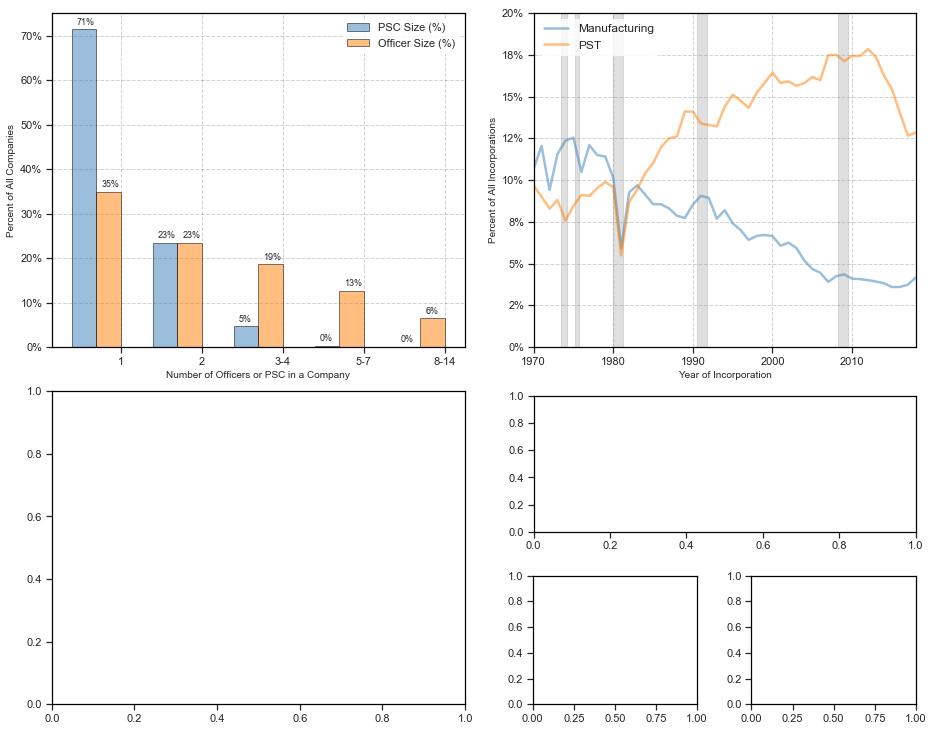

In [30]:
fig = plt.figure(figsize=(6, 3))
sns.set_context("notebook", font_scale=1)

gs1 = gridspec.GridSpec(4, 4)
gs1.update(left=0.00, right=2, top=3.2, bottom=0, hspace=0.15)
ax1 = plt.subplot(gs1[0:2, 0:2])

gs2 = gridspec.GridSpec(4, 4)
gs2.update(left=0.15, right=2, top=3.2, bottom=0, hspace=0.15)
ax2 = plt.subplot(gs2[0:2, 2:4])

gs3 = gridspec.GridSpec(4, 4)
gs3.update(left=0.00, right=2, top=3.0, bottom=0, hspace=0.15)
ax3 = plt.subplot(gs3[2:4, 0:2])

gs4 = gridspec.GridSpec(4, 4)
gs4.update(left=0.15, right=2, top=2.875, bottom=0.075, hspace=0.15)
ax4 = plt.subplot(gs4[2:3, 2:4])

gs5 = gridspec.GridSpec(4, 4)
gs5.update(left=0.2, right=1.95, top=2.65, bottom=0, hspace=0.15)
ax5 = plt.subplot(gs5[3:4, 2:3])

gs6 = gridspec.GridSpec(4, 4)
gs6.update(left=0.25, right=2, top=2.65, bottom=0, hspace=0.15)
ax6 = plt.subplot(gs6[3:4, 3:4])

width = 0.6
ch_counts_toplot[['PSC Size (%)',
                  'Officer Size (%)']][0:5].plot(kind='bar',
                                                 color = ['#377eb8',
                                                          '#ff7f00'],
                                                 ec = 'k',
                                                 ax=ax1,
                                                 width=width,
                                                 position=1,
                                                 alpha=0.5)
ax1.grid(b=True, which='major', color='k',
          linestyle='--', alpha=0.175)
ax1.set_ylabel('Percent of All Companies', fontsize=10)
ax1.set_xlabel('Number of Officers or PSC in a Company', fontsize=10)
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc='upper right',
            frameon = True, edgecolor='w')
vals = ax1.get_yticks()    
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax1.set_xticklabels(ch_counts_toplot.index, rotation=0)
for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate('{:.0%}'.format(height),
                 (p.get_x()+.2*width,
                  p.get_y() + height + 0.01),
                 fontsize=9)
df_years_sic_pc[['Manufacturing', 'PST']].plot(ax=ax2,
                                               alpha=0.5,
                                               linewidth=2.5,
                                               color=['#377eb8',
                                                      '#ff7f00'])
ax2.grid(b=True, which='major', color='k',
          linestyle='--', alpha=0.175)
h1, l1 = ax2.get_legend_handles_labels()
ax2.legend(loc='upper left',
            fontsize=12,
            frameon=True,
            edgecolor='w')
ax2.set_ylim(0,.2)
ax2.set_xlim(1970, 2018);
ax2.set_ylabel('Percent of All Incorporations', fontsize=10)
ax2.set_xlabel('Year of Incorporation', fontsize=10)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
ax2.axvspan(1973.5, 1974.25, alpha=0.25, color='grey')
ax2.axvspan(1975.25, 1975.75, alpha=0.25, color='grey')
ax2.axvspan(1980, 1981.25, alpha=0.25, color='grey')
ax2.axvspan(1990.5, 1991.75, alpha=0.25, color='grey')
ax2.axvspan(2008.25, 2009.5, alpha=0.25, color='grey')

#df_degrees['size'] = (np.log(df_degrees['self_degree'])/30)+0.1
gs3 = df_degrees.plot.scatter(x='self_degree',
                              y='av_friend_degree',
                              s=0.2, ax=ax3,
                              color = '#377eb8')
gs3.set_xlim(0, sorted(centrality.DegreeCentrality(Giant).run().scores(),
                       reverse=True)[1])
gs3.set_ylim(0, sorted(centrality.DegreeCentrality(Giant).run().scores(),
                       reverse=True)[1])
gs3.set_xlabel("Number of Edges", fontsize=10)
gs3.set_ylabel("Average Number of Edges of Edges", fontsize=10)
gs3.grid(b=True, which='major', color='k',
          linestyle='--', alpha=0.175)

gs4 = c_size_toplot[:10].plot(ax=ax4, kind='bar',
                              color = '#ff7f00', alpha=0.6,
                              edgecolor='k')
gs4.set_xlabel('Component Size', fontsize=10)
ax4.grid(b=True, which='major', color='k',
          linestyle='--', alpha=0.175)

gs5 = pd.Series(sorted_deg_cent_Entire).plot(ax=ax5,
                                             color='#ff7f00',
                                             alpha=0.8)
ax5.grid(b=True, which='major', color='k',
          linestyle='--', alpha=0.175)
gs5.set_xscale("log")
gs5.set_xlabel("Degree", fontsize=10)
gs5.set_yscale("log")
gs5.set_ylabel("Number of Nodes", fontsize=10)

gs6 = pd.Series(sorted_deg_cent_Giant).plot(ax=ax6,
                                            color = '#377eb8',
                                            alpha=0.8)
ax6.grid(b=True, which='mdajor', color='k',
          linestyle='--', alpha=0.175)
gs6.set_xscale("log")
gs6.set_xlabel("Degree", fontsize=10)
gs6.set_yscale("log")
gs6.set_ylabel("Number of Nodes", fontsize=10)

plt.autoscale()
fig.savefig(os.path.join(Figures,
                         'Company_Descriptives.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Company_Descriptives.pdf'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                          'Company_Descriptives.png'),
            dpi=400, bbox_inches='tight')

## 7. Gender

### 7.1 Groupby and merge the engineered datasets

* Calculate mean females per SIC
* Calculate number of females per SIC
* Drop by sics with less than either 1000 psc\officers
* Tabulate frequency of forenames
* Tabulate female percentage across company size
* Rescale some percentages
* etc, etc, etc

In [26]:
ch_off_bysic, ch_psc_bysic, companies_merged, ch_merged_bysic, ch_forenames = gen_gen_toplot(ch_off, ch_psc)

### 7.2 Plot Figure 

Plot the gender-related figure here. Note the slightly tricky use of gridspec and subplot to make the spacing between the subplots as seemless as possible. The hbar graphs (2nd and 3rd row visually, 3rd and 4th in gridspec method) are actually two different axes.

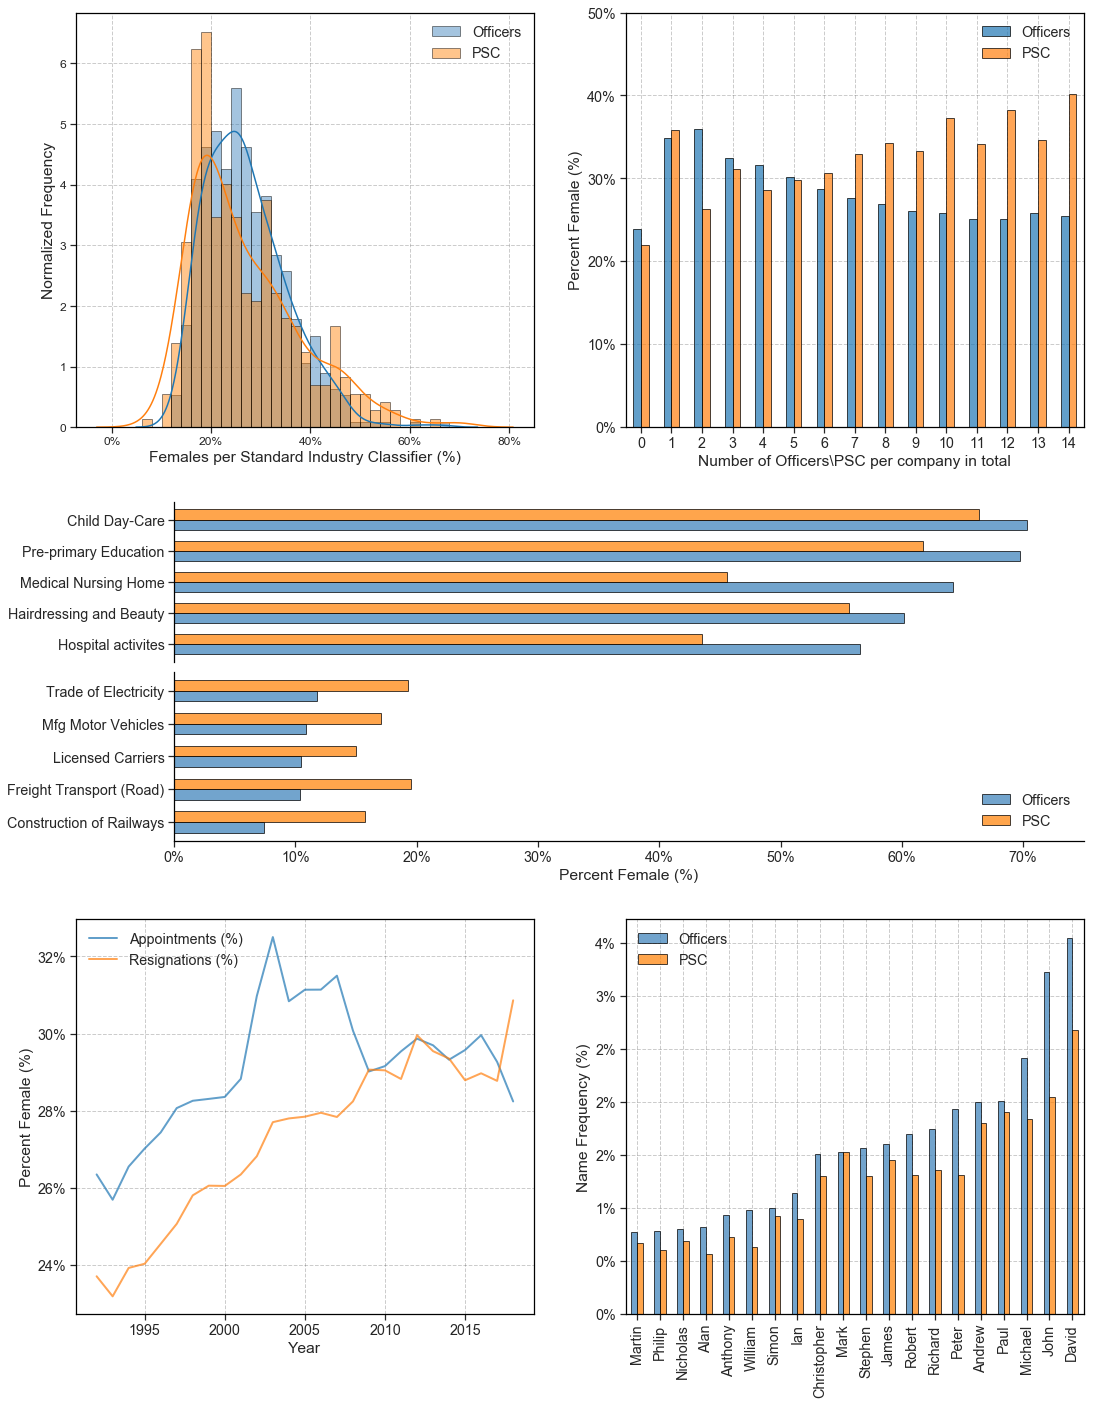

In [27]:
fig = plt.figure(figsize=(7, 5.65))
sns.set_context("notebook", font_scale=1.3)

gs1 = gridspec.GridSpec(6, 2)
gs1.update(left=0.00, right=2, top=3.2, bottom=0, hspace=0.15)
ax1 = plt.subplot(gs1[0:2, 0])

gs2 = gridspec.GridSpec(6, 2)
gs2.update(left=0.0, right=2, top=3.2, bottom=0, hspace=0.15)
ax2 = plt.subplot(gs2[0:2, 1])

gs3 = gridspec.GridSpec(6, 2)
gs3.update(left=0.195, right=2, top=3.1, bottom=-0.05, hspace=0.4)
ax3 = plt.subplot(gs3[2, :])

gs4 = gridspec.GridSpec(6, 2)
gs4.update(left=0.195, right=2, top=3.325, bottom=0.0, hspace=0.4)
ax4 = plt.subplot(gs4[3, :])

gs5 = gridspec.GridSpec(6, 2)
gs5.update(left=0.00, right=2, top=3.05, bottom=0, hspace=0.15)
ax5 = plt.subplot(gs5[4:6, 0])

gs6 = gridspec.GridSpec(6, 2)
gs6.update(left=0.00, right=2, top=3.05, bottom=0, hspace=0.15)
ax6 = plt.subplot(gs6[4:6, 1])

np.warnings.filterwarnings('ignore')
g1 = sns.distplot(ch_off_bysic['MeanFemale'],
                  ax=ax1,
                  kde_kws={'gridsize': 500},
                  hist_kws={'color': '#377eb8',
                            'ec': 'k', 'alpha': 0.45},
                  label='Companies House',
                  bins=np.arange(.0, .70, .02))
g1 = sns.distplot(ch_psc_bysic['MeanFemale'],
                  ax=ax1,
                  kde_kws={'gridsize': 500},
                  hist_kws={'color': '#ff7f00',
                            'ec': 'k', 'alpha': 0.45},
                  label='Companies House',
                  bins=np.arange(.0, .70, .02))
g1.tick_params(axis='both', which='major', labelsize=12)
g1.legend(['Officers', 'PSC'], loc='upper right', frameon=False)
#g1.set_xlim(0, .70)
g1.set_xlabel('Females per Standard Industry Classifier (%)')
g1.set_ylabel('Normalized Frequency')
vals = g1.get_xticks()
g1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
g1.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

g2 = companies_merged[['Female officer (%)', 'Female PSC (%)']][0:15]\
    .plot(kind='bar', ax=ax2, ec='k', alpha=0.7)
g2.set_ylim(0, .5)
g2.legend(['Officers', 'PSC'],  loc='upper right', frameon=False)
g2.set_xlabel('Number of Officers\PSC per company in total')
g2.set_ylabel('Percent Female (%)')
vals = g2.get_yticks()
g2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
g2.set_xticklabels(g2.get_xticks(),rotation=0)
g2.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

g3 = ch_merged_bysic[['MeanFemale_PSC', 'MeanFemale_Officer']]\
    .sort_values(by='MeanFemale_PSC', ascending=True)[-5:]\
    .plot(kind='barh', ax=ax3, width=.65, alpha=0.7, legend=False,
          edgecolor='k', color=['#377eb8', '#ff7f00'])
g3.set_ylabel('')
g3.set_xlabel('')
g3.xaxis.set_ticks_position('none')
g3.axes.get_xaxis().set_visible(False)
g3.set_xlim(0, .75)
sns.despine(ax=ax3, bottom=True, right=True)

g4 = ch_merged_bysic[['MeanFemale_PSC', 'MeanFemale_Officer']]\
    .sort_values(by='MeanFemale_PSC', ascending=True)[:5]\
    .plot(kind='barh', ax=ax4, width=.65, alpha=0.7,
          edgecolor='k', color=['#377eb8', '#ff7f00'])
g4.set_xlim(0, .75)
g4.set_ylabel('')
g4.set_xlabel('Percent Female (%)')
vals = g4.get_xticks()
g4.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
ax4.legend(['Officers', 'PSC'],
           loc='lower right', frameon=False)
sns.despine(ax=ax4, bottom=False, right=True)

g5 = timely_df_a_gender[['Female Appointments (%)',
                         'Female Resignations (%)']].plot(kind='line',
                                                          ax=ax5,
                                                          legend=False,
                                                          alpha=0.7,
                                                          linewidth=2)
g5.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
g5.set_ylabel('Percent Female (%)')
g5.set_xlabel('Year')
vals = g5.get_yticks()
g5.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
              
ax5.legend(['Appointments (%)', 'Resignations (%)'],
           loc='upper left', frameon=False)

g6 = ch_forenames[-20:].\
    plot(kind='bar', color=['#377eb8', '#ff7f00'],
         ax=ax6, edgecolor='k', alpha=0.7)
g6.set_xlabel('')
g6.set_ylabel('Name Frequency (%)')
g6.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
ax6.legend(['Officers', 'PSC'],
           loc='upper left', frameon=False)
vals = g6.get_yticks()
g6.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
fig.tight_layout()
fig.savefig(os.path.join(Figures,
                         'Gender_Gaps_in_Companies_House.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Gender_Gaps_in_Companies_House.pdf'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Gender_Gaps_in_Companies_House.png'),
            dpi=800, bbox_inches='tight')

### 7.3 Supplementary Stats

Print out some supplementary stats for inclusion in the free text:

In [38]:
print('There are {}% female PSC on average!'.\
      format(round(ch_psc[(ch_psc['isfemale']==1.0) |
                          (ch_psc['isfemale']==0.0)]['isfemale'].\
                   mean()*100,2)))
print('There are {}% female Officers on average!'.\
      format(round(ch_off[(ch_off['isfemale']==1.0) |
                          (ch_off['isfemale']==0.0)]['isfemale'].\
                   mean()*100,2)))

There are 27.75% female PSC on average!
There are 29.31% female Officers on average!


In [39]:
for year in range(1992,2019):
    active = ch_off[(ch_off['isfemale']==1.0) |
                    (ch_off['isfemale']==0.0)]\
    [(year >= ch_off[(ch_off['isfemale']==1.0) |
                     (ch_off['isfemale']==0.0)]['Appointed_DT'].dt.year) &
                    ((year <= ch_off[(ch_off['isfemale']==1.0) |
                                     (ch_off['isfemale']==0.0)]['Resigned_DT'].dt.year) |
                    (ch_off[(ch_off['isfemale']==1.0) |
                            (ch_off['isfemale']==0.0)]['Resigned_DT'].dt.year).isnull())]
    print('The pecent of active officers which were female in ' + str(year) + ' was: '
          + str(round(active['isfemale'].mean(), 3)*100))

The pecent of active officers which were female in 1992 was: 25.8
The pecent of active officers which were female in 1993 was: 25.7
The pecent of active officers which were female in 1994 was: 26.0
The pecent of active officers which were female in 1995 was: 26.3
The pecent of active officers which were female in 1996 was: 26.700000000000003
The pecent of active officers which were female in 1997 was: 27.200000000000003
The pecent of active officers which were female in 1998 was: 27.6
The pecent of active officers which were female in 1999 was: 27.900000000000002
The pecent of active officers which were female in 2000 was: 28.1
The pecent of active officers which were female in 2001 was: 28.4
The pecent of active officers which were female in 2002 was: 29.099999999999998
The pecent of active officers which were female in 2003 was: 30.0
The pecent of active officers which were female in 2004 was: 30.3
The pecent of active officers which were female in 2005 was: 30.7
The pecent of active

In [40]:
print('The SIC with the most female PSC is: ' +
      str(ch_psc_bysic['MeanFemale'].\
          sort_values(ascending=False).index[0]) +
      '(' + 
      str(round(ch_psc_bysic['MeanFemale'].\
                sort_values(ascending=False)[0],3)) +
      '%)')

print('The SIC with the most female Officers is: ' +
      str(ch_off_bysic['MeanFemale'].\
          sort_values(ascending=False).head(1).index[0]) +
      '(' + 
      str(round(ch_off_bysic['MeanFemale'].\
                sort_values(ascending=False).head(1)[0],3)) +
      '%)')

The SIC with the most female PSC is: Child Day-Care(0.703%)
The SIC with the most female Officers is: Child Day-Care(0.663%)


In [41]:
print('The SIC with the least female PSC is: ' +
      str(ch_psc_bysic['MeanFemale'].sort_values().head(1).index[0]) +
      '(' + 
      str(round(ch_psc_bysic['MeanFemale'].sort_values().head(1)[0],3)) +
      '%)')

print('The SIC with the least female Officers is: ' +
      str(ch_off_bysic['MeanFemale'].sort_values().head(1).index[0]) +
      '(' + 
      str(round(ch_off_bysic['MeanFemale'].sort_values().head(1)[0],3)) +
      '%)')

The SIC with the least female PSC is: Construction of Railways(0.074%)
The SIC with the least female Officers is: 7415 - Holding Companies including Head Offices(0.122%)


Calculate here the biggest change since 1992:

In [42]:
sic_delta_gender = pd.DataFrame((sic_timely_off_gender['2018']-
                                 sic_timely_off_gender['1992']).\
                                sort_values(ascending=True),
                                columns = ['% Change'])
sic_delta_gender.style

In [43]:
print('There are ' + 
      str(len(ch_off[(ch_off['isfemale']==1.0) |
                     (ch_off['isfemale']==0.0)][ch_off[(ch_off['isfemale']==1.0) |
                                                       (ch_off['isfemale']==0.0)]['Officer Role']=='director'])) +
            ' company directors in our Officer Database. Of them ' +
      str(round(ch_off[ch_off['Officer Role']=='director']['isfemale'].mean()*100,3)) +
      '% are female.')
print('There are ' + 
      str(len(ch_off[(ch_off['isfemale']==1.0) |
                     (ch_off['isfemale']==0.0)][ch_off[(ch_off['isfemale']==1) |
                                                       (ch_off['isfemale']==0.0)]['Officer Role']=='secretary'])) +
      ' company secretarys in our Officer Database. Of them ' +
      str(round(ch_off[ch_off['Officer Role']=='secretary']['isfemale'].mean()*100,3)) +
      '% are female.')

There are 10427104 company directors in our Officer Database. Of them 25.815% are female.
There are 2435454 company secretarys in our Officer Database. Of them 44.472% are female.


In [44]:
ch_forenames = ch_forenames.reset_index().sort_values(by = 'count_officer_forenames',
                                                    ascending=False)
ch_forenames['gender'] = ch_forenames.apply(gender_by_row, axis=1)
ch_forenames.index = np.arange(1, len(ch_forenames) + 1)
holder = 'The most commonly seen female officer names are: '
for index, row in islice(ch_forenames[ch_forenames['gender']=='female'].iterrows(),5):
    holder = holder + str(row['forename']) +\
             ' (' + str(round(row['count_officer_forenames']*100,2)) +\
             '%, ' + 'ranked ' + str(index) + '); '
print(holder[:-2])

The most commonly seen female officer names are: Susan (0.72%, ranked 22); Sarah (0.56%, ranked 30); Elizabeth (0.48%, ranked 35); Helen (0.41%, ranked 40); Margaret (0.39%, ranked 43)


Calculate when we'll reach gender parity (50% female) for Officers:

In [45]:
pct_fem = timely_df_a_gender['Female Appointments (%)'].tail(1).item()
year = 2018
while pct_fem<0.5:
    pct_fem = pct_fem*(1+timely_df_a_gender['Female Appointments (%)'].pct_change().mean())
    year +=1
print('We estimate that we will reach gender parity in Female Appointments in year ' + 
      str(year) + '...')

We estimate that we will reach gender parity in Female Appointments in year 2206...


## 8. Age

### 8.1 Groupby and merge the engineered datasets

Just like before: relegate the wrangling code into a support function to make the notebook cleaner:

In [46]:
ch_merged_bysic, ch_av_age, companies_merged, ch_psc_bysic, ch_off_bysic = gen_age_toplot(ch_off, ch_psc, ch_accounts)

### 8.2 Visualization for Age

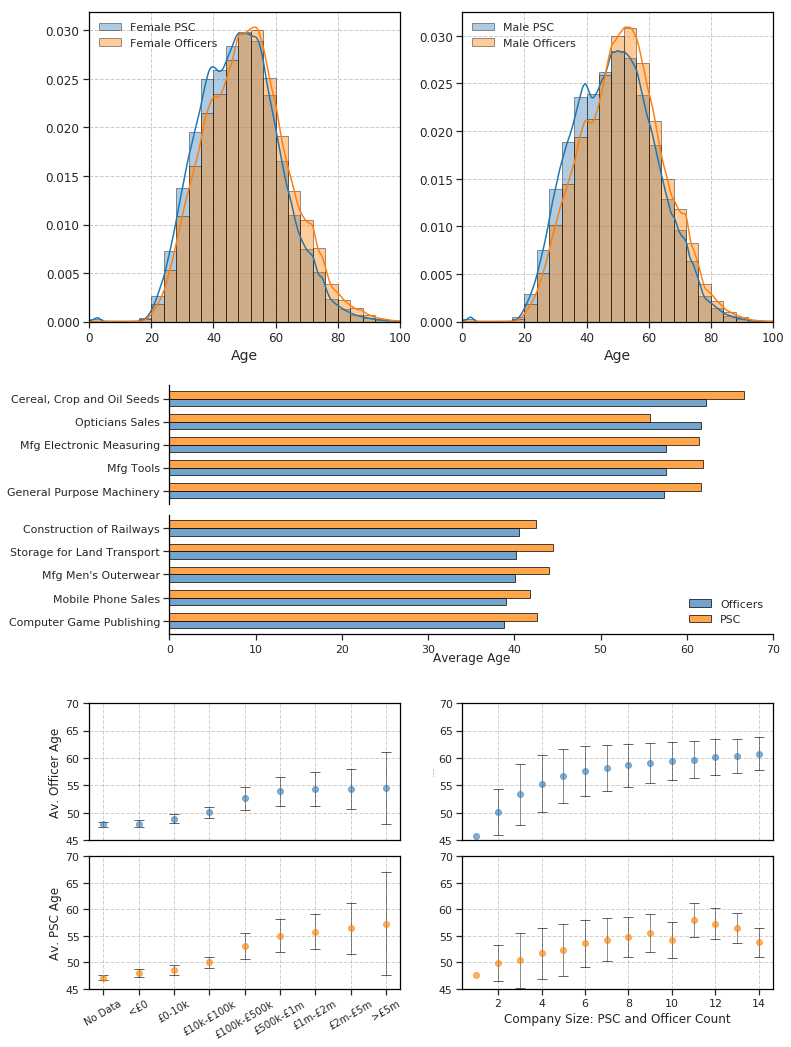

In [47]:
fig = plt.figure(figsize=(4.75, 5.65))
sns.set_context("notebook", font_scale=1)

gs1 = gridspec.GridSpec(8, 2)
gs1.update(left=0.00, right=2, top=3.2, bottom=0, hspace=0.15)
ax1 = plt.subplot(gs1[0:2, 0])

gs2 = gridspec.GridSpec(8, 2)
gs2.update(left=0.00, right=2, top=3.2, bottom=0, hspace=0.15)
ax2 = plt.subplot(gs2[0:2, 1])

gs3 = gridspec.GridSpec(8, 2)
gs3.update(left=0.235, right=2, top=3.1, bottom=-0.05, hspace=0.4)
ax3 = plt.subplot(gs3[2:3, :])

gs4 = gridspec.GridSpec(8, 2)
gs4.update(left=0.235, right=2, top=3.2, bottom=0.025, hspace=0.4)
ax4 = plt.subplot(gs4[3:4, :])

gs5 = gridspec.GridSpec(8, 2)
gs5.update(left=0.00, right=2, top=3.055, bottom=0, hspace=0.15)
ax5 = plt.subplot(gs5[4:5, 0])

gs6 = gridspec.GridSpec(8, 2)
gs6.update(left=0.00, right=2, top=3, bottom=0.05, hspace=0.15)
ax6 = plt.subplot(gs6[5:6, 0])

gs7 = gridspec.GridSpec(8, 2)
gs7.update(left=0.00, right=2, top=3.055, bottom=0, hspace=0.15)
ax7 = plt.subplot(gs7[4:5, 1])

gs8 = gridspec.GridSpec(8, 2)
gs8.update(left=0.00, right=2, top=3, bottom=0.05, hspace=0.15)
ax8 = plt.subplot(gs8[5:6, 1])

g1 = sns.distplot(ch_psc[(ch_psc['Age'].notnull()) & 
                         (ch_psc['isfemale']==1.0)]['Age'],
                 ax=ax1,
                 kde_kws={'gridsize': 500},
                 hist_kws={'color': '#377eb8', 'ec': 'k', 'alpha': 0.4},
                 label='PSC',
                 bins=np.arange(0, 100, 4))
g1 = sns.distplot(ch_off[(ch_off['Age'].notnull()) &
                         (ch_off['isfemale']==1.0) &
                         (ch_off['Resigned'].isnull())]['Age'],
                 ax=ax1,
                 kde_kws={'gridsize': 500},
                 hist_kws={'color': '#ff7f00', 'ec': 'k', 'alpha': 0.4},
                 label='PSC',
                 bins=np.arange(0, 100, 4))
g1.set_xlabel('Age', fontsize=14)
g1.set_xlim(0, 100)
g1.legend(['Female PSC', 'Female Officers'], loc='upper left', frameon=False)
g1.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
g1.tick_params(axis='both', which='major', labelsize=12)

g2 = sns.distplot(ch_psc[(ch_psc['Age'].notnull()) & (ch_psc['isfemale']==0.0)]['Age'],
                 ax=ax2,
                 kde_kws={'gridsize': 500},
                 hist_kws={'color': '#377eb8', 'ec': 'k', 'alpha': 0.4},
                 label='PSC',
                 bins=np.arange(0, 100, 4))
g2 = sns.distplot(ch_off[(ch_off['Age'].notnull()) &
                         (ch_off['isfemale']==0.0) &
                         (ch_off['Resigned'].isnull())]['Age'],
                 ax=ax2,
                 kde_kws={'gridsize': 500},
                 hist_kws={'color': '#ff7f00', 'ec': 'k', 'alpha': 0.4},
                 label='PSC',
                 bins=np.arange(0, 100, 4))
g2.set_xlabel('Age', fontsize=14)
g2.set_xlim(0, 100)
g2.legend(['Male PSC', 'Male Officers'], loc='upper left', frameon=False)
g2.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
g2.tick_params(axis='both', which='major', labelsize=12)

g3 = ch_merged_bysic[['Average PSC Age',
                      'Average Officer Age']]\
     .rename({'25730 - Manufacture of tools':'Mfg Tools'}, axis=0)\
    .sort_values(by='Average PSC Age', ascending=True)[-5:]\
    .plot(kind='barh', ax=ax3, width=.65, alpha=0.7, legend=False,
          edgecolor='k', color=['#377eb8', '#ff7f00'])
g3.set_ylabel('')
g3.set_xlabel('')
g3.xaxis.set_ticks_position('none')
g3.axes.get_xaxis().set_visible(False)
g3.set_xlim(0, 70)
sns.despine(ax=ax3, bottom=True, right=True)

g4 = ch_merged_bysic[['Average PSC Age', 'Average Officer Age']]\
    .sort_values(by='Average PSC Age', ascending=True)[:5]\
    .plot(kind='barh', ax=ax4, width=.65, alpha=0.7,
          edgecolor='k', color=['#377eb8', '#ff7f00'])
g4.set_ylabel('')
g4.set_xlabel('Average Age', labelpad=-3)
ax4.legend(['Officers', 'PSC'],
           loc='lower right', frameon=False)
g4.set_xlim(0, 70)
sns.despine(ax=ax4, bottom=False, right=True)

y = ch_av_age.groupby('CurrentAssets_cat')['Average Officer Age'].mean().sort_values(ascending=True)
x = ch_av_age.groupby('CurrentAssets_cat')['Average Officer Age'].mean().sort_values(ascending=True).index
error = ch_av_age.groupby('CurrentAssets_cat')['Average Officer Age'].sem().sort_values(ascending=True)*50
ax5.errorbar(x, y, yerr=error, fmt='o', ecolor='k', color='#377eb8', alpha = 0.6, capsize=5, elinewidth=0.75)
ax5.grid(b=True, which='major', color='k', linestyle='--', alpha=0.175)
ax5.xaxis.set_ticks_position('none')
#ax5.axes.get_xaxis().set_visible(False)
ax5.set_ylabel('Av. PSC Age')
ax5.set_ylim(45,70)
ax5.set_ylabel('Av. Officer Age')
for tick in ax5.get_xticklabels():
    tick.set_color('w')#bit hacky, but required to hide tick labels

y = ch_av_age.groupby('CurrentAssets_cat')['Average PSC Age'].mean().sort_values(ascending=True)
x = ch_av_age.groupby('CurrentAssets_cat')['Average PSC Age'].mean().sort_values(ascending=True).index
error = ch_av_age.groupby('CurrentAssets_cat')['Average PSC Age'].sem().sort_values(ascending=True)*50
ax6.errorbar(x, y, yerr=error, fmt='o', ecolor='k', color='#ff7f00', alpha = 0.6, capsize=5, elinewidth=0.75)
ax6.grid(b=True, which='major', color='k', linestyle='--', alpha=0.175)
ax6.set_ylabel('Av. PSC Age')
#ax6.set_xlabel('Company Size: Current Assets as of 2017')
ax6.set_ylim(45,70)
for tick in ax6.get_xticklabels():
    tick.set_rotation(30)
    tick.set_fontsize(10)

y = companies_merged['Officer Age Mean'][0:15]
x = companies_merged['Officer Age Mean'][0:15].index
error = companies_merged['Officer Age SEM'][0:15]
ax7.errorbar(x, y, yerr=error, fmt='o', ecolor='k', color='#377eb8', alpha = 0.6, capsize=5, elinewidth=0.75)
ax7.grid(b=True, which='major', color='k', linestyle='--', alpha=0.175)
ax7.xaxis.set_ticks_position('none')
#ax7.axes.get_xaxis().set_visible(False)
ax7.set_ylabel('Av. PSC Age', fontsize=1)#bit hacky, but required to hide tick labels
ax7.set_ylabel('Av. Officer Age')
ax7.set_ylim(45,70)
for tick in ax7.get_xticklabels():
    tick.set_color('w')#bit hacky, but required to hide tick labels

y = companies_merged['PSC Age Mean'][0:15]
x = companies_merged['PSC Age Mean'][0:15].index
error = companies_merged['PSC Age SEM'][0:15]
ax8.errorbar(x, y, yerr=error, fmt='o', ecolor='k', color='#ff7f00', alpha = 0.6, capsize=5, elinewidth=0.75)
ax8.grid(b=True, which='major', color='k', linestyle='--', alpha=0.175)
ax8.set_xlabel('Company Size: PSC and Officer Count')
#ax8.set_ylabel('Av. PSC Age')
ax8.set_ylim(45,70)

fig.savefig(os.path.join(Figures,
                         'Age_in_Companies_House.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Age_in_Companies_House.pdf'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Age_in_Companies_House.png'),
            dpi=800, bbox_inches='tight')


### 4.3 Supplementary Stats

Print out some supplementary stats for inclusion in the free text in the paper

In [48]:
ch_av_age.groupby('CurrentAssets_cat')['Average PSC Age'].mean().sort_values(ascending=True)

CurrentAssets_cat
No Data        47.107201
<£0            47.983823
£0-10k         48.578009
£10k-£100k     49.986750
£100k-£500k    53.035732
£500k-£1m      55.048103
£1m-£2m        55.790741
£2m-£5m        56.414618
>£5m           57.312119
Name: Average PSC Age, dtype: float64

In [49]:
ch_av_age.groupby('CurrentAssets_cat')['Average Officer Age'].mean().sort_values(ascending=True)

CurrentAssets_cat
No Data        47.914595
<£0            48.005628
£0-10k         48.927958
£10k-£100k     50.091200
£100k-£500k    52.648286
£500k-£1m      53.981246
£1m-£2m        54.333499
£2m-£5m        54.340700
>£5m           54.581428
Name: Average Officer Age, dtype: float64

In [50]:
ch_merged_bysic[['Average PSC Age', 'Average Officer Age']]\
    .sort_values(by='Average PSC Age', ascending=True)[:5]

Average PSC Age  Average Officer Age
SICCode.SicText_1                                               
Computer Game Publishing          38.791932            42.641195
Mobile Phone Sales                38.990529            41.756673
Mfg Men's Outerwear               40.128463            44.046177
Storage for Land Transport        40.158837            44.444701
Construction of Railways          40.529814            42.460569

In [51]:
ch_merged_bysic[['Average PSC Age', 'Average Officer Age']]\
    .sort_values(by='Average PSC Age', ascending=True)[-5:]

Average PSC Age  Average Officer Age
SICCode.SicText_1                                               
General Purpose Machinery         57.340688            61.669267
Mfg Tools                         57.568248            61.890204
Mfg Electronic Measuring          57.598201            61.457863
Opticians Sales                   61.672484            55.730155
Cereal, Crop and Oil Seeds        62.222858            66.645455

In [52]:
print('The average age of female PSC on average: {}!'.\
      format(round(ch_psc[((ch_psc['isfemale']==1.0) |
                           (ch_psc['isfemale']==0.0)) &
                          (ch_psc['Age'].notnull())][ch_psc[((ch_psc['isfemale']==1.0) |
                                                             (ch_psc['isfemale']==0.0)) &
                                                            (ch_psc['Age'].notnull())]['isfemale']==1.0]['Age'].mean(),2)))
print('The average age of male PSC on average: {}!'.\
      format(round(ch_psc[((ch_psc['isfemale']==1.0) |
                           (ch_psc['isfemale']==0.0)) & (ch_psc['Age'].notnull())][ch_psc[((ch_psc['isfemale']==1.0) |
                                                                                           (ch_psc['isfemale']==0.0)) &
                                                                                          (ch_psc['Age'].notnull())]['isfemale']==0.0]['Age'].mean(),2)))
print('The average age of female Officers on average: {}!'.\
      format(round(ch_off[((ch_off['isfemale']==1.0) |
                           (ch_off['isfemale']==0.0)) &
                          (ch_off['Age'].notnull())][ch_off[((ch_off['isfemale']==1.0) |
                                                             (ch_off['isfemale']==0.0)) &
                                                            (ch_off['Age'].notnull())]['isfemale']==1.0]['Age'].mean(),2)))
print('The average age of male Officers on average: {}!'.format(round(ch_off[((ch_off['isfemale']==1.0) |
                                                                              (ch_off['isfemale']==0.0)) &
                                                                             (ch_off['Age'].notnull())][ch_off[((ch_off['isfemale']==1.0) |
                                                                                                                (ch_off['isfemale']==0.0)) & (ch_off['Age'].notnull())]['isfemale']==0.0]['Age'].mean(),2)))

The average age of female PSC on average: 48.45!
The average age of male PSC on average: 49.11!
The average age of female Officers on average: 54.85!
The average age of male Officers on average: 56.47!


In [53]:
print('The SIC with the oldest average PSC is: ' +
      str(ch_psc_bysic['Average PSC Age'].\
          sort_values(ascending=False).index[0]) +
      ' (' + 
      str(round(ch_psc_bysic['Average PSC Age'].\
                sort_values(ascending=False)[0],3)) +
      ' years)')

print('The SIC with the oldest average Officers is: ' +
      str(ch_off_bysic['Average Officer Age'].\
          sort_values(ascending=False).head(1).index[0]) +
      ' (' + 
      str(round(ch_off_bysic['Average Officer Age'].\
                sort_values(ascending=False).head(1)[0],3)) +
      ' years)')

The SIC with the oldest average PSC is: Cereal, Crop and Oil Seeds (62.223 years)
The SIC with the oldest average Officers is: 2852 - General mechanical engineering (71.156 years)


In [54]:
print('The SIC with the youngest average PSC is: ' +
      str(ch_psc_bysic['Average PSC Age'].\
          sort_values().head(1).index[0]) +
      ' (' + 
      str(round(ch_psc_bysic['Average PSC Age'].\
                sort_values().head(1)[0],3)) +
      ' years)')

print('The SIC with the youngest average Officers is: ' +
      str(ch_off_bysic['Average Officer Age'].\
          sort_values().head(1).index[0]) +
      ' (' + 
      str(round(ch_off_bysic['Average Officer Age'].\
                sort_values().head(1)[0],3)) +
      ' years)')

The SIC with the youngest average PSC is: Computer Game Publishing (38.792 years)
The SIC with the youngest average Officers is: Mobile Phone Sales (41.757 years)


In [55]:
for people in ch_off[ch_off['Age'].notnull()]['Officer Role'].unique():
    print('There are ' + 
          str(len(ch_off[ch_off['Age'].notnull()][ch_off[ch_off['Age'].\
                                                         notnull()]['Officer Role']==people])) +
          ' company ' + str(people) + ' in our Officer Database.' + 
          'Their average age is ' +
          str(round(ch_off[ch_off['Age'].notnull()][ch_off[ch_off['Age'].\
                                                           notnull()]['Officer Role']==people]['Age'].\
                    mean(),3)) + '.')
print('Note: no dates of birth for company secretarys in our Officer Database.')

There are 11467712 company director in our Officer Database.Their average age is 55.383.
There are 53277 company nominee-director in our Officer Database.Their average age is 57.701.
There are 123632 company llp-designated-member in our Officer Database.Their average age is 52.483.
There are 142476 company llp-member in our Officer Database.Their average age is 52.322.
There are 266 company member-of-an-administrative-organ in our Officer Database.Their average age is 53.123.
There are 5 company member-of-a-management-organ in our Officer Database.Their average age is 52.288.
There are 7 company member-of-a-supervisory-organ in our Officer Database.Their average age is 57.963.
Note: no dates of birth for company secretarys in our Officer Database.


## 9. Nationalities

### 9.1 As before, lets wrangle:

In [56]:
off_nat_merged, psc_nat_merged = gen_nat_toplot(ch_psc, ch_off, ons_df)

### 9.2 Lets output tables

#### 9.2.1 First for Officers

In [57]:
off_nat_merged = off_nat_merged[off_nat_merged['count']>1000]
off_nat_merged['average female'] = off_nat_merged['average female'].round(decimals=2)
off_nat_merged['Average Age'] = off_nat_merged['Average Age'].round(decimals=1)
off_nat_merged = off_nat_merged.set_index('nationality_cleaned')
off_nat_merged.drop('uk_pop', axis=1)[0:15]

count  per person  average female  Average Age
nationality_cleaned                                                   
UK                   10358466        0.18            0.27         56.3
US                     186218        1.17            0.17         59.5
France                  83102        0.47            0.23         52.6
Germany                 82271        0.27            0.21         54.1
Italy                   74214        0.31            0.26         50.4
India                   74013        0.09            0.28         43.2
Poland                  68807        0.08            0.28         39.8
China                   54936        0.26            0.29         42.7
Australia               53466        0.38            0.24         52.8
Romania                 49370        0.12            0.21         36.4
Netherlands             43478        0.60            0.17         54.8
Japan                   32834        0.75            0.10         63.6
Canada                  32152        0.34            0.21         56.7
Pakistan                31316        0.06            0.13         39.7
Spain                   29025        0.19            0.27         48.0

#### 9.2.2 Then for PSC

In [58]:
psc_nat_merged = psc_nat_merged[psc_nat_merged['count']>1000]
psc_nat_merged['average female'] = psc_nat_merged['average female'].round(decimals=2)
psc_nat_merged['Average Age'] = psc_nat_merged['Average Age'].round(decimals=1)
psc_nat_merged = psc_nat_merged.set_index('nationality_cleaned')
psc_nat_merged.drop('uk_pop', axis=1)[0:15]

count  per person  average female  Average Age
nationality_cleaned                                                  
UK                   4010820        0.07            0.28         49.8
Poland                 53717        0.06            0.24         39.3
India                  46957        0.05            0.29         39.2
Romania                43604        0.11            0.17         36.0
China                  40973        0.20            0.43         40.6
Italy                  39917        0.17            0.23         46.9
Germany                32326        0.10            0.27         49.9
France                 29470        0.17            0.30         45.4
US                     26155        0.16            0.27         53.2
Pakistan               20850        0.04            0.15         37.6
Nigeria                17302        0.08            0.28         41.8
Australia              17086        0.12            0.35         45.4
Bulgaria               16968        0.18            0.22         39.3
Philippines            16247        0.11            0.58         40.2
Spain                  14146        0.09            0.31         43.0

### 9.3 Some summary statistics:

In [59]:
print('Most population adjusted PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['per person']==psc_nat_merged['per person'].\
               max()].index[0]) +
      ' with ' + str(psc_nat_merged['per person'].max()) +
      ' PSC per person')

print('Least population adjusted PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['per person']==psc_nat_merged['per person'].\
               min()].index[0]) +
      ' with ' + str(psc_nat_merged['per person'].min()) +
      ' PSC per person')

print('Most population adjusted Officers is ' + 
      str(off_nat_merged[off_nat_merged['per person']==off_nat_merged['per person'].\
               max()].index[0]) +
      ' with ' + str(off_nat_merged['per person'].max()) +
      ' Officers per person')

print('Least population adjusted Officers is ' + 
      str(off_nat_merged[off_nat_merged['per person']==off_nat_merged['per person'].\
               min()].index[0]) +
      ' with ' + str(off_nat_merged['per person'].min()) +
      ' Officers per person')
print('Highest female average PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['average female']==psc_nat_merged['average female'].\
               max()].index[0]) +
      ' with ' + str(psc_nat_merged['average female'].max()*100) +
      '% females')

print('Lowest female average PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['average female']==psc_nat_merged['average female'].\
               min()].index[0]) +
      ' with ' + str(psc_nat_merged['average female'].min()*100) +
      '% females')

print('Highest female average Officers is ' + 
      str(off_nat_merged[off_nat_merged['average female']==off_nat_merged['average female'].\
               max()].index[0]) +
      ' with ' + str(off_nat_merged['average female'].max()*100) +
      '% females')

print('Lowest female average Officers is ' + 
      str(off_nat_merged[off_nat_merged['average female']==off_nat_merged['average female'].\
               min()].index[0]) +
      ' with ' + str(off_nat_merged['average female'].min()*100) +
      '% females')

print('Oldest average PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['Average Age']==psc_nat_merged['Average Age'].\
               max()].index[0]) +
      ' with ' + str(psc_nat_merged['Average Age'].max()) +
      ' average years')

print('Youngest average PSC is ' + 
      str(psc_nat_merged[psc_nat_merged['Average Age']==psc_nat_merged['Average Age'].\
               min()].index[0]) +
      ' with ' + str(psc_nat_merged['Average Age'].min()) +
      ' average years')

print('Oldest average Officers is ' + 
      str(off_nat_merged[off_nat_merged['Average Age']==off_nat_merged['Average Age'].\
               max()].index[0]) +
      ' with ' + str(off_nat_merged['Average Age'].max()) +
      ' average years')

print('Youngest average Officers is ' + 
      str(off_nat_merged[off_nat_merged['Average Age']==off_nat_merged['Average Age'].\
               min()].index[0]) +
      ' with ' + str(off_nat_merged['Average Age'].min()) +
      ' average years')

Most population adjusted PSC is Sweden with 0.31 PSC per person
Least population adjusted PSC is Kenya with 0.01 PSC per person
Most population adjusted Officers is US with 1.17 Officers per person
Least population adjusted Officers is Kenya with 0.03 Officers per person
Highest female average PSC is Thailand with 71.0% females
Lowest female average PSC is Afghanistan with 9.0% females
Highest female average Officers is Seychelles with 67.0% females
Lowest female average Officers is United Arab Emirates with 6.0% females
Oldest average PSC is US with 53.2 average years
Youngest average PSC is Afghanistan with 33.2 average years
Oldest average Officers is Japan with 63.6 average years
Youngest average Officers is Afghanistan with 35.3 average years


In [60]:
off_nat_merged.drop('uk_pop', axis=1)[0:15].to_csv(os.path.join(Tables,
                                   'officer_nationality_results.csv'), sep = '&')
psc_nat_merged.drop('uk_pop', axis=1)[0:15].to_csv(os.path.join(Tables,
                                   'psc_nationality_results.csv'), sep = '&')

### 9.4 Join for paper and save tables:

Rename columns, merge, order on office count, merge and save:

In [61]:
off_nat_merged = off_nat_merged.rename({'count':'Officer Count',
                                        'per person':'Officer Ratio',
                                        'average female':'Officer Female',
                                        'Average Age':'Officer Age'}, axis=1).drop('uk_pop', axis=1)
psc_nat_merged = psc_nat_merged.rename({'count':'PSC Count',
                                        'per person':'PSC Ratio',
                                        'average female':'PSC Female',
                                        'Average Age':'PSC Age'}, axis=1).drop('uk_pop', axis=1)
pd.merge(off_nat_merged,
         psc_nat_merged,
         how='left',
         left_index = True,
         right_index = True)[0:15].to_csv(os.path.join(Tables,
                                                       'joint_nationality_results.csv'),
                                          sep = '&')

In [62]:
print('The entire percent of Officers from the UK is: '+
      str(round(len(ch_off[(ch_off['nationality_cleaned'].notnull()) &
                     (ch_off['nationality_cleaned']=='UK')])/
          len(ch_off[ch_off['nationality_cleaned'].notnull()])*100,2)) + '%.')
print('The entire percent of PSC from the UK is: '+
      str(round(len(ch_psc[(ch_psc['nationality_cleaned'].notnull()) &
                     (ch_psc['nationality_cleaned']=='UK')])/
          len(ch_psc[ch_psc['nationality_cleaned'].notnull()])*100,2)) + '%.')

The entire percent of Officers from the UK is: 63.94%.
The entire percent of PSC from the UK is: 71.45%.


In [63]:
for year in range(1992,2019):
    print('The percent of Officers from the UK appointed in ' + str(year) + ' was: '+
          str(round(len(ch_off[(ch_off['nationality_cleaned'].notnull()) &
                               (ch_off['nationality_cleaned']=='UK') &
                               (ch_off['Appointed'].str.contains(str(year)))])/
              len(ch_off[(ch_off['nationality_cleaned'].notnull()) &
                         (ch_off['Appointed'].str.contains(str(year)))])*100,2)) + '%.')

The percent of Officers from the UK appointed in 1992 was: 60.74%.
The percent of Officers from the UK appointed in 1993 was: 61.59%.
The percent of Officers from the UK appointed in 1994 was: 61.68%.
The percent of Officers from the UK appointed in 1995 was: 60.67%.
The percent of Officers from the UK appointed in 1996 was: 59.89%.
The percent of Officers from the UK appointed in 1997 was: 58.82%.
The percent of Officers from the UK appointed in 1998 was: 57.96%.
The percent of Officers from the UK appointed in 1999 was: 57.42%.
The percent of Officers from the UK appointed in 2000 was: 56.91%.
The percent of Officers from the UK appointed in 2001 was: 56.43%.
The percent of Officers from the UK appointed in 2002 was: 53.68%.
The percent of Officers from the UK appointed in 2003 was: 52.65%.
The percent of Officers from the UK appointed in 2004 was: 55.13%.
The percent of Officers from the UK appointed in 2005 was: 54.94%.
The percent of Officers from the UK appointed in 2006 was: 55.

## 10. Residences

### 10.1 Wrangling

In [31]:
map_uk_df_merged, ch_psc_grp_NUTS, ch_off_grp_NUTS, map_london_df = gen_res_toplot(ch_off, ch_psc, map_london_df, map_uk_df, ch_accounts)

### 10.2 Group into NUTS regions for the bar chart:

In [32]:
Nuts_Counts = pd.merge(ch_psc_grp_NUTS[['NUTS118NM',
                                        'PSC Count',
                                        'Total PSC (%)',
                                        'CurNetLiaAssetsPPSC',
                                        'CurNetAssPPSC (%)']],
                       ch_off_grp_NUTS[['Officer Count',
                                        'Total Officers (%)',
                                        'CurNetLiaAssetsPOff',
                                        'CurNetAssPOff (%)']],
                       left_index=True, right_index=True)
Nuts_Counts = Nuts_Counts.sort_values(by = 'Officer Count', ascending=False)
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace(' \(England\)','')
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace('Yorkshire and The Humber',
                                   'Yorks/Humb')
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace('Northern Ireland',
                                   'N.I.')
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace('East of England',
                                   'E. England')
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace('West Midlands',
                                   'West Mids')
Nuts_Counts['NUTS118NM'] = Nuts_Counts['NUTS118NM'].str.\
                           replace('East Midlands',
                                   'East Mids')
Nuts_Counts

NUTS118NM  PSC Count  Total PSC (%)  CurNetLiaAssetsPPSC  \
0       London    1261134      25.400325         2.216700e+10   
1   South East     758512      15.277085         1.177173e+10   
2   North West     503867      10.148315         7.294606e+09   
3   E. England     490202       9.873090         8.652278e+09   
4    West Mids     379261       7.638643         6.454091e+09   
5   South West     377255       7.598241         5.332279e+09   
6   Yorks/Humb     313216       6.308440         4.854033e+09   
7    East Mids     295030       5.942158         5.505629e+09   
8     Scotland     253349       5.102667         3.809169e+09   
9        Wales     145277       2.926004         2.239304e+09   
10  North East     113581       2.287619         1.320490e+09   
11        N.I.      74347       1.497413         1.450661e+09   

    CurNetAssPPSC (%)  Officer Count  Total Officers (%)  CurNetLiaAssetsPOff  \
0           27.417014        4199001           27.654885         2.249065e+10   
1           14.559729        2458701           16.193159         9.345287e+09   
2            9.022253        1398523            9.210760         6.505830e+09   
3           10.701475        1389127            9.148878         5.946797e+09   
4            7.982672        1259089            8.292439         4.502626e+09   
5            6.595170        1038585            6.840186         4.326445e+09   
6            6.003657         896200            5.902430         3.639109e+09   
7            6.809577         788792            5.195034         3.235336e+09   
8            4.711329         774305            5.099621         3.190586e+09   
9            2.769658         444438            2.927097         2.477641e+09   
10           1.633233         309054            2.035449         8.285358e+08   
11           1.794234         227763            1.500061         8.207536e+08   

    CurNetAssPOff (%)  
0           33.413733  
1           13.884034  
2            9.665531  
3            8.834991  
4            6.689426  
5            6.427680  
6            5.406524  
7            4.806649  
8            4.740166  
9            3.680963  
10           1.230933  
11           1.219371

### 10.3 Make the choropleth maps:

In [45]:
map_uk_df_merged = map_uk_df_merged.drop(['E','EC','N','NW','SE',
                                          'SW','W','WC','ZE',
                                          'GY', 'JE'], axis=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=800)
ax1 = map_uk_df_merged.plot(column='Officer Count',
                            cmap=plt.get_cmap('Blues'),
                            linewidth=0.1, ax=ax1, edgecolor='k')
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Blues'),
                           norm=plt.Normalize(vmin=map_london_df['Officer Count'].min(),
                                              vmax=map_london_df['Officer Count'].max()))
sm._A = []
cbar_ax1 = fig.add_axes([0.1, 0.2, 0.01, 0.2])
fig.colorbar(sm, cax=cbar_ax1, orientation="vertical")
cbar_ax1.set_title('Officer\nCount',size=8)
cbar_ax1.tick_params(axis='both', which='major', labelsize=8)
inset_fig = inset_axes(ax1, width=1.5, height=1.1, loc=3,
                       bbox_to_anchor=(0.37, 0.49),
                       bbox_transform=ax1.figure.transFigure)
gs3 = map_london_df.plot(column='Officer Count',
                         cmap=plt.get_cmap('Blues'),
                         linewidth=0.1,
                         ax=inset_fig, edgecolor='k')
gs3.axes.get_xaxis().set_visible(False)
gs3.axes.get_yaxis().set_visible(False)
x1, y1 = [535000, 535000], [175000, 550000]
x2, y2 = [535000, 700000], [175000, 550000]
ax1.plot(x1, y1, x2, y2, marker = None, linewidth = 0.5, color='k')
ax2 = map_uk_df_merged.plot(column='Non-London PSC (%)',
                            cmap=plt.get_cmap('Oranges'),
                            linewidth=0.1, ax=ax2, edgecolor='k')
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Oranges'),
                           norm=plt.Normalize(vmin=map_london_df['PSC Count'].min(),
                           vmax=map_london_df['PSC Count'].max()))
sm._A = []
cbar_ax2 = fig.add_axes([0.575, 0.2, 0.01, 0.2])
fig.colorbar(sm, cax=cbar_ax2, orientation="vertical")
cbar_ax2.set_title('PSC\nCount',size=8)
cbar_ax2.tick_params(axis='both', which='major', labelsize=8)
#ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
inset_fig = inset_axes(ax1, width=1.5, height=1.1, loc=3,
                       bbox_to_anchor=(0.85, 0.49),
                       bbox_transform=ax2.figure.transFigure)
gs3 = map_london_df.plot(column='PSC Count', cmap=plt.get_cmap('Oranges'),
                         linewidth=0.1, ax=inset_fig, edgecolor='k')
gs3.axes.get_xaxis().set_visible(False)
gs3.axes.get_yaxis().set_visible(False)
x1, y1 = [535000, 535000], [175000, 550000]
x2, y2 = [535000, 700000], [175000, 550000]
ax2.plot(x1, y1, x2, y2, marker = None, linewidth = 0.5, color='k')
ax1.xaxis.set_tick_params(labelsize=9)
ax1.yaxis.set_tick_params(labelsize=9)
ax2.xaxis.set_tick_params(labelsize=9)

#ax1.grid(b=True, which='major', color='k', linestyle='--', alpha=0.1)
#ax2.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

fig.tight_layout()
fig.savefig(os.path.join(Figures, 'Residences.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Residences.pdf'),
            box_inches='tight')
fig.savefig(os.path.join(Figures, 'Residences.png'),
            dpi=800, bbox_inches='tight')

### 10.4 Plot the bar chart of residences across NUTS2: 

Note: ideally these should be in one gridspec figure, but its a little bit tricky with the insets of the choropleths....

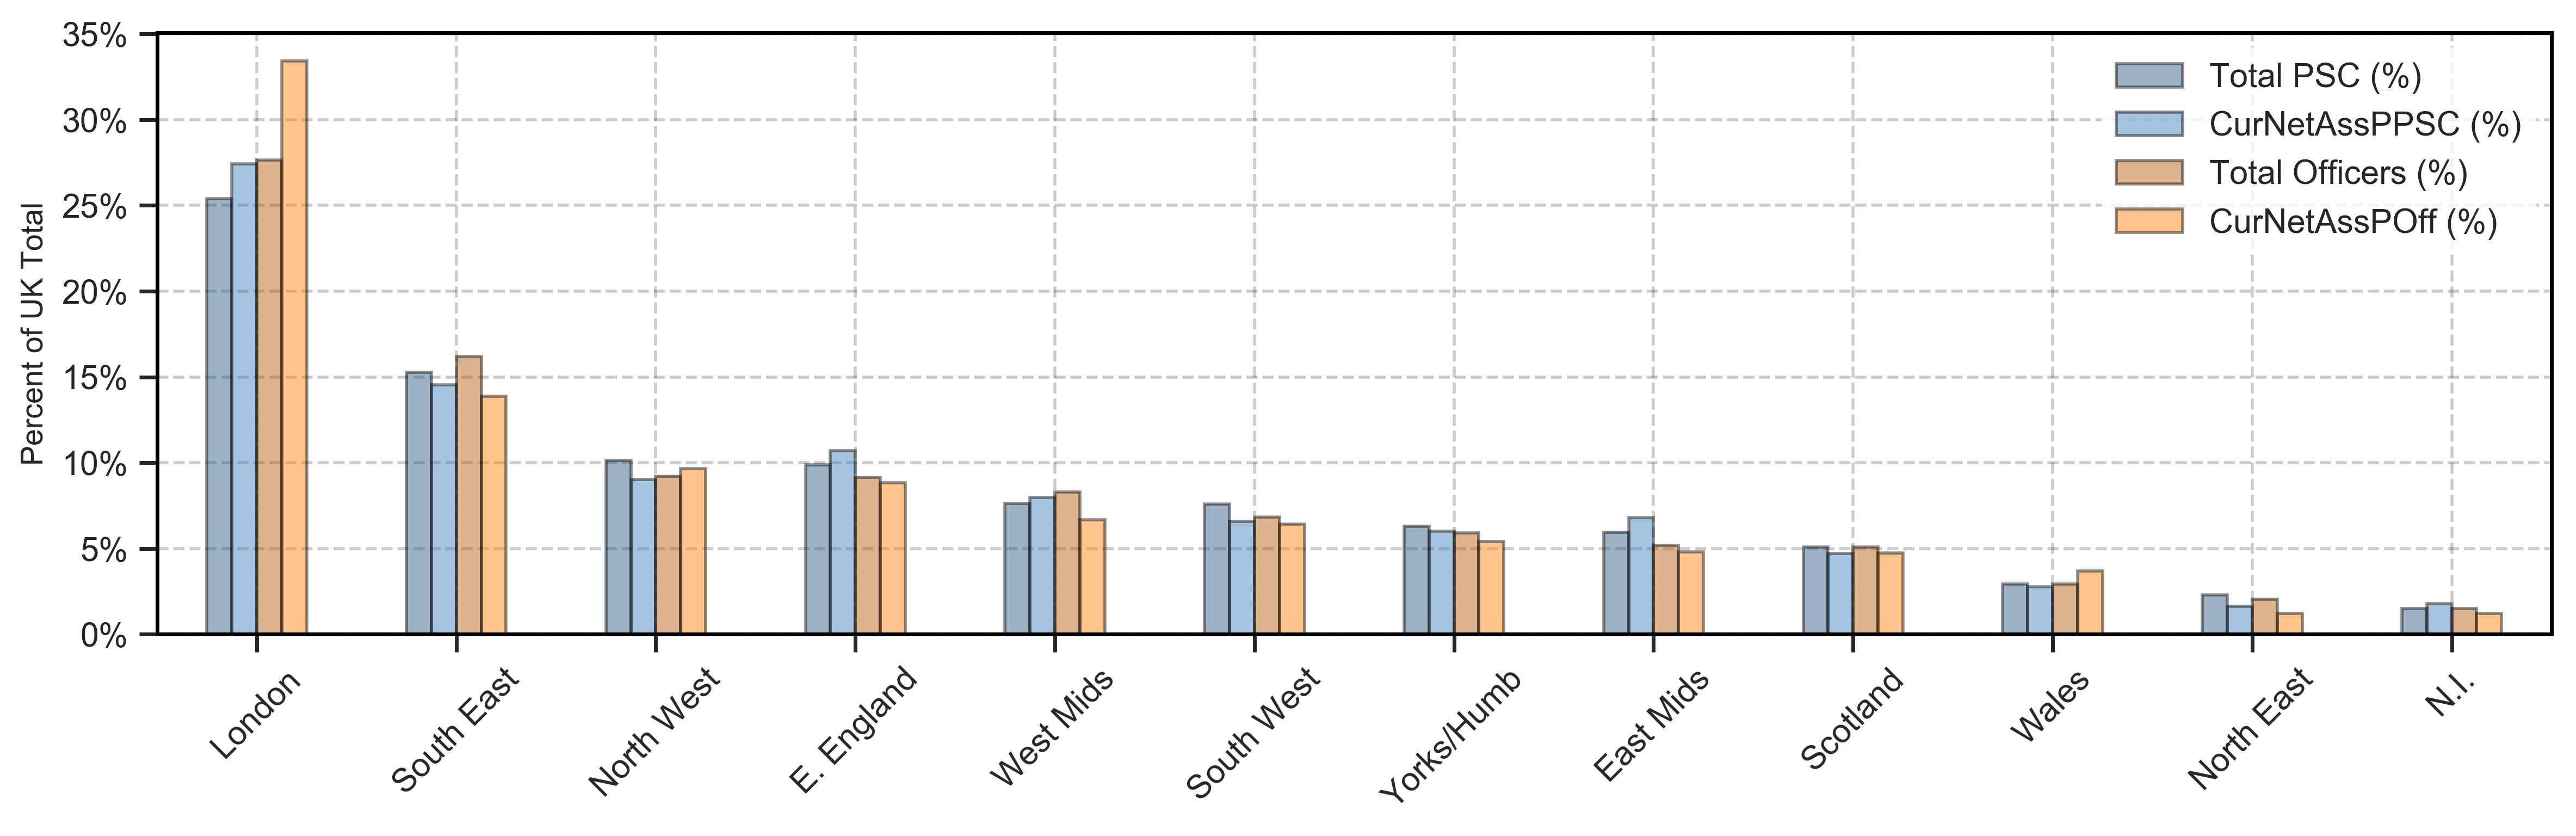

In [41]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,4), dpi=400)
ax1 = (Nuts_Counts.set_index('NUTS118NM')[['Total PSC (%)',
                                          'CurNetAssPPSC (%)',
                                          'Total Officers (%)',
                                          'CurNetAssPOff (%)']]/100).plot(ax=ax1,
                                                                     kind='bar',
                                                                     edgecolor='k',
                                                                     alpha=0.45,
                                                                    color = ['#265880',
                                                                             '#377eb8',
                                                                             '#b25800',
                                                                             '#ff7f00'])
ax1.legend(loc='upper right', frameon = True, edgecolor='w')
ax1.set_xlabel('')
ax1.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
ax1.set_xticklabels(Nuts_Counts.set_index('NUTS118NM').index, rotation=45)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax1.set_ylabel('Percent of UK Total', fontsize=10)
fig.tight_layout()
fig.savefig(os.path.join(Figures,
                         'Residences_Bar.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Residences_Bar.pdf'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Residences_Bar.png'),
            dpi=800, bbox_inches='tight')

In [ ]:
A simple correlation analysis across our four metrics of instance here.

In [68]:
(Nuts_Counts.set_index('NUTS118NM')[['Total PSC (%)',
                                          'CurNetAssPPSC (%)',
                                          'Total Officers (%)',
                                          'CurNetAssPOff (%)']]/100).corr()

Total PSC (%)  CurNetAssPPSC (%)  Total Officers (%)  \
Total PSC (%)            1.000000           0.993548            0.995988   
CurNetAssPPSC (%)        0.993548           1.000000            0.992933   
Total Officers (%)       0.995988           0.992933            1.000000   
CurNetAssPOff (%)        0.978499           0.984929            0.984122   

                    CurNetAssPOff (%)  
Total PSC (%)                0.978499  
CurNetAssPPSC (%)            0.984929  
Total Officers (%)           0.984122  
CurNetAssPOff (%)            1.000000

### 10.5  Build in Indices of deprivation:

Note: one simple @todo is to decompose the multiple index into its constitutents. Left for later...

In [69]:
postcodes_LSOA = postcodes[postcodes['Country']=='England'].\
                 drop_duplicates('LSOA Code').\
                 set_index('LSOA Code')[['Index of Multiple Deprivation']]
ch_psc_with_geo_grouped_LSOA = ch_psc[ch_psc['Country']=='England'].\
                               groupby(['LSOA Code']).size()
ch_off_with_geo_grouped_LSOA = ch_off[ch_off['Country']=='England'].\
                               groupby(['LSOA Code']).size()
merged_df = pd.merge(postcodes_LSOA,
                     pd.DataFrame(ch_off_with_geo_grouped_LSOA,
                                  columns=['Officer Count by LSOA']),
                     right_index = True, left_index = True)
merged_df = pd.merge(merged_df,
                     pd.DataFrame(ch_psc_with_geo_grouped_LSOA,
                                  columns=['PSC Count by LSOA']),
                     right_index = True, left_index = True)                          

##### 10.5.1 Check that the histogram of the ranks is uniform and that theres no mistakes.

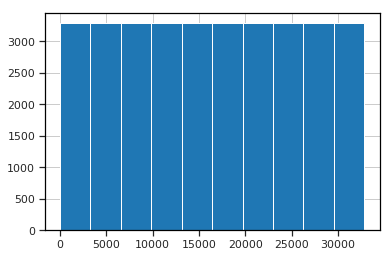

In [70]:
merged_df['Index of Multiple Deprivation'] = pd.to_numeric(merged_df['Index of Multiple Deprivation'])
merged_df['Index of Multiple Deprivation'].hist()

In [71]:
merged_df['Officer Rank'] = merged_df['Officer Count by LSOA'].rank(ascending=False)
merged_df['PSC Rank'] = merged_df['PSC Count by LSOA'].rank(ascending=False)

#### 10.5.2 Plot a kdeplot

Is there a better way to visualise spearmans rank correlations with high n and low rho??

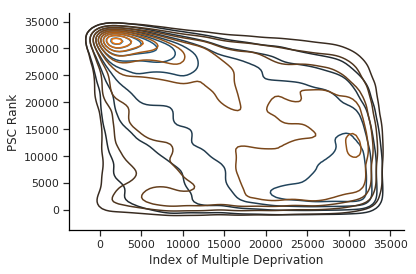

In [72]:
ax = sns.kdeplot(merged_df['Index of Multiple Deprivation'],
                 merged_df['Officer Rank'])
ax = sns.kdeplot(merged_df['Index of Multiple Deprivation'],
                 merged_df['PSC Rank'])
sns.despine()

#### 10.5.3 Calculate spearmans rank correlations

In [73]:
scipy.stats.spearmanr(merged_df['Index of Multiple Deprivation'],
                      merged_df['Officer Rank'])

SpearmanrResult(correlation=-0.42659721954821317, pvalue=0.0)

In [74]:
scipy.stats.spearmanr(merged_df['Index of Multiple Deprivation'],
                      merged_df['PSC Rank'])

SpearmanrResult(correlation=-0.2736357067591812, pvalue=0.0)

### 11. Occupation

(This likely does not represent a full substantive part of the paper lest we think of something more to do with it)

In [75]:
ch_off.groupby(['Occupation']).Occupation.agg('count')\
                               .to_frame('count')\
                               .reset_index()\
                               .sort_values(by='count',
                                            ascending=False)[0:10]

Occupation    count
127879              Director  2939716
90838       Company Director  1203035
377108               Retired   376313
2715              Accountant   274023
305311                  None   229939
275285     Managing Director   210015
422511             Solicitor   194580
100133            Consultant   190007
65275   Chartered Accountant   174506
270912               Manager   159785

In [76]:
print('The number of directors which identifiy their occupation as directors is: ' + 
      str(round(((len(ch_off[(ch_off['Occupation'].str.lower().str.contains('director', na=False)) & 
                   (ch_off['Officer Role']=='director')])))/
          (len(ch_off[ch_off['Officer Role']=='director']))*100,2)) + '%.')

The number of directors which identifiy their occupation as directors is: 42.32%.


In [77]:
print('The number of directors which identifiy their occupation as accountant is: ' + 
      str(round(((len(ch_off[(ch_off['Occupation'].str.lower().str.contains('accountant', na=False)) & 
                   (ch_off['Officer Role']=='director')])))/
          (len(ch_off[ch_off['Officer Role']=='director']))*100,2)) + '%.')

The number of directors which identifiy their occupation as accountant is: 4.0%.


In [78]:
print('The number of directors which identifiy their occupation as accountant is: ' + 
      str(round(((len(ch_off[(ch_off['Occupation'].str.lower().str.contains('solicitor', na=False)) & 
                   (ch_off['Officer Role']=='director')])))/
          (len(ch_off[ch_off['Officer Role']=='director']))*100,2)) + '%.')

The number of directors which identifiy their occupation as accountant is: 1.75%.


### 12. The 'Business Case for  Diversity' Revisited

### 12.1 Wrangling

Note: the ch_generate_regdf involves the use of our blau generating function, and is very time consuming at present (~8-10 hours. @todo: figure out a better way to slice the df rather than re-indexing every time...

In [130]:
ch_reg = ch_generate_regdf(ch_off, ch_basic, ch_psc, ch_accounts, 1)

100%|██████████| 221233/221233 [7:31:13<00:00,  7.98it/s]  


### 12.2 Regressions for main table

Do 5 regressions, each time on a different officer cutoff (i.e. minimum officer size 2, 3, 4, 5, 6) to avoid any claims of a forking path.

In [131]:
results = bus_div_reg(ch_reg, 1, os.path.join(Tables, 'reg_1.csv'))

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     39.48
Date:                Tue, 12 Mar 2019   Prob (F-statistic):          5.66e-185
Time:                        07:29:36   Log-Likelihood:                -85985.
No. Observations:               13319   AIC:                         1.720e+05
Df Residuals:                   13293   BIC:                         1.722e+05
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [132]:
bus_div_reg(ch_reg, 2, os.path.join(Tables, 'reg_2.csv'))

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.338
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           1.80e-25
Time:                        07:29:36   Log-Likelihood:                -28210.
No. Observations:                4560   AIC:                         5.647e+04
Df Residuals:                    4534   BIC:                         5.664e+04
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [133]:
bus_div_reg(ch_reg, 3, os.path.join(Tables, 'reg_3.csv'))

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.544
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           8.06e-09
Time:                        07:29:36   Log-Likelihood:                -12761.
No. Observations:                2086   AIC:                         2.557e+04
Df Residuals:                    2060   BIC:                         2.572e+04
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [134]:
bus_div_reg(ch_reg, 4, os.path.join(Tables, 'reg_4.csv'))

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.649
Date:                Tue, 12 Mar 2019   Prob (F-statistic):             0.0307
Time:                        07:29:36   Log-Likelihood:                -5382.7
No. Observations:                 903   AIC:                         1.081e+04
Df Residuals:                     880   BIC:                         1.092e+04
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [135]:
bus_div_reg(ch_reg, 5, os.path.join(Tables, 'reg_5.csv'))

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                     1.380
Date:                Tue, 12 Mar 2019   Prob (F-statistic):              0.118
Time:                        07:29:36   Log-Likelihood:                -2509.4
No. Observations:                 427   AIC:                             5065.
Df Residuals:                     404   BIC:                             5158.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### 12.3 Generate a plot for visualisation

Rotate the the depvar across 3 measurs of capital (tobins Q) as of the 2009 ASR paper, with the officer cutoff as a grid

In [143]:
df_gend, df_age, df_nat = gen_reg_toplot(ch_reg, range(2,7))

### 12.4 Visualise this as a form of coefficient plots:

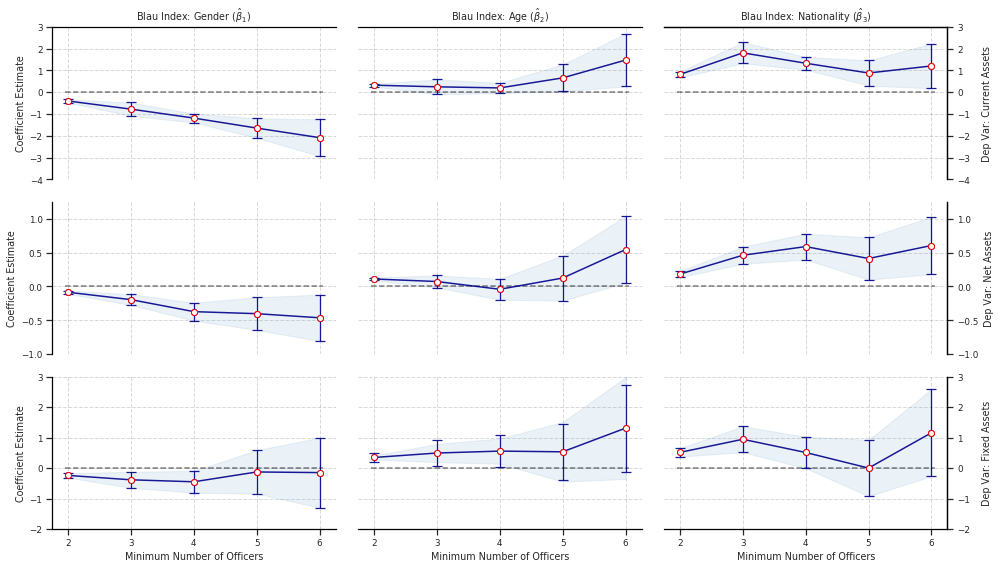

In [157]:
sns.set_context("notebook", font_scale=.8)
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=False,
                        sharex=True, figsize=(14,8))
ax1 = axs[0,0]
ax1.errorbar(y=df_gend['Cur_Ass_Est'],
             x=df_gend.index,
             yerr=df_gend['Cur_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax1.errorbar(y=df_gend['Cur_Ass_Est'],
             x=df_gend.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax1.fill_between(df_gend.index,
                 pd.to_numeric(df_gend['Cur_Ass_Est']-df_gend['Cur_Ass_StdErr']*1.96),
                 pd.to_numeric(df_gend['Cur_Ass_Est']+df_gend['Cur_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=False, bottom=True, right=True, left=False, ax=ax1)
ax1.tick_params(axis='x', which='both', bottom=False,
               top=False, labelbottom=False, labeltop=False)
ax1.set_ylabel('Gender (Min Size)')
ax1.set_ylabel('Coefficient Estimate')
ax1.set_title(r'Blau Index: Gender ($\hat{\beta}_1$)')

ax2 = axs[0,1]
ax2.errorbar(y=df_age['Cur_Ass_Est'],
             x=df_age.index,
             yerr=df_age['Cur_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax2.errorbar(y=df_age['Cur_Ass_Est'],
             x=df_age.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax2.fill_between(df_age.index,
                 pd.to_numeric(df_age['Cur_Ass_Est']-df_age['Cur_Ass_StdErr']*1.96),
                 pd.to_numeric(df_age['Cur_Ass_Est']+df_age['Cur_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=False, bottom=True, right=True, left=True, ax=ax2)
ax2.tick_params(axis='x', which='both', bottom=False,
                left = False, top=False, labelbottom=False, labeltop=False)
ax2.tick_params(axis='y', which='both', bottom=False, labelleft=False, 
                left = False, top=False, labelbottom=False)
ax2.set_title(r'Blau Index: Age ($\hat{\beta}_2$)')

ax3 = axs[0,2]
ax3.errorbar(y=df_nat['Cur_Ass_Est'],
             x=df_nat.index,
             yerr=df_nat['Cur_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax3.errorbar(y=df_nat['Cur_Ass_Est'],
             x=df_nat.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax3.fill_between(df_nat.index,
                 pd.to_numeric(df_nat['Cur_Ass_Est']-df_nat['Cur_Ass_StdErr']*1.96),
                 pd.to_numeric(df_nat['Cur_Ass_Est']+df_nat['Cur_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=False, bottom=True, right=False, left=True, ax=ax3)
ax3.yaxis.tick_right()
ax3a = ax3.twinx()
ax3a.set_ylabel('Dep Var: Current Assets', labelpad=35)
sns.despine(top=False, bottom=True, right=False, left=True, ax=ax3a)
ax3a.tick_params(axis='y', which='both', bottom=False, right=False,
                 top=False, labelbottom=False, left=False, labelright=False,
                 labelleft=False)
ax3a.tick_params(axis='x', which='both', bottom=False, right=False,
                 left=False, top=False, labelbottom=False, labeltop=False)
ax3.tick_params(axis='y', which='both', bottom=False, right=True,
                labelleft=False,
                top=False, labelbottom=False, left=False, labelright=True)
ax3.tick_params(axis='x', which='both', bottom=False, right=False,
                left=False, top=False, labelbottom=False, labeltop=False)
ax3.set_title(r'Blau Index: Nationality ($\hat{\beta}_3$)')

ax4 = axs[1,0]
ax4.errorbar(y=df_gend['Net_Cur_Est'],
             x=df_gend.index,
             yerr=df_gend['Net_Cur_StdErr']*1.96,
             color='darkblue',
             capsize=5, elinewidth=1.25,
             fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax4.errorbar(y=df_gend['Net_Cur_Est'],
             x=df_gend.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax4.fill_between(df_gend.index,
                 pd.to_numeric(df_gend['Net_Cur_Est']-df_gend['Net_Cur_StdErr']*1.96),
                 pd.to_numeric(df_gend['Net_Cur_Est']+df_gend['Net_Cur_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=True, bottom=True, right=True, left=False, ax=ax4)
ax4.tick_params(axis='x', which='both', bottom=False,
               top=False, labelbottom=False, left = False)
ax4.set_ylabel('Coefficient Estimate')

ax5 = axs[1,1]
ax5.errorbar(y=df_age['Net_Cur_Est'],
             x=df_age.index,
             yerr=df_age['Net_Cur_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax5.errorbar(y=df_age['Net_Cur_Est'],
             x=df_age.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax5.fill_between(df_age.index,
                 pd.to_numeric(df_age['Net_Cur_Est']-df_age['Net_Cur_StdErr']*1.96),
                 pd.to_numeric(df_age['Net_Cur_Est']+df_age['Net_Cur_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=True, bottom=True, right=True, left=True, ax=ax5)
ax5.tick_params(axis='y', which='both', bottom=False, labelleft=False, 
               left = False, top=False, labelbottom=False)
ax5.tick_params(axis='x', which='both', bottom=False,
                left = False, top=False, labelbottom=False)

ax6 = axs[1,2]
ax6.errorbar(y=df_nat['Net_Cur_Est'],
             x=df_nat.index,
             yerr=df_nat['Net_Cur_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax6.errorbar(y=df_nat['Net_Cur_Est'],
             x=df_nat.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax6.fill_between(df_nat.index,
                 pd.to_numeric(df_nat['Net_Cur_Est']-df_nat['Net_Cur_StdErr']*1.96),
                 pd.to_numeric(df_nat['Net_Cur_Est']+df_nat['Net_Cur_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=True, bottom=True, right=False, left=True, ax=ax6)
ax6.yaxis.tick_right()
ax6a = ax6.twinx()
ax6a.set_ylabel('Dep Var: Net Assets', labelpad=37)
sns.despine(top=True, bottom=True, right=False, left=True, ax=ax6a)
ax6a.tick_params(axis='y', which='both', bottom=False, right=False,
                 top=False, labelbottom=False, left=False, labelright=False,
                 labelleft=False)
ax6a.tick_params(axis='x', which='both', bottom=False, right=False,
                 left=False, top=False, labelbottom=False, labeltop=False)
ax6.tick_params(axis='y', which='both', bottom=False, right=True,
                labelleft=False,
                top=False, labelbottom=False, left=False, labelright=True)
ax6.tick_params(axis='x', which='both', bottom=False, right=False,
                left=False, top=False, labelbottom=False, labeltop=False)

ax7 = axs[2,0]
ax7.errorbar(y=df_gend['Fix_Ass_Est'],
             x=df_gend.index,
             yerr=df_gend['Fix_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax7.errorbar(y=df_gend['Fix_Ass_Est'],
             x=df_gend.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax7.fill_between(df_gend.index,
                 pd.to_numeric(df_gend['Fix_Ass_Est']-df_gend['Fix_Ass_StdErr']*1.96),
                 pd.to_numeric(df_gend['Fix_Ass_Est']+df_gend['Fix_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
ax7.set_ylabel('Coefficient Estimate')
ax7.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.despine(top=True, bottom=False, right=True, left=False, ax=ax7)

ax8 = axs[2,1]
ax8.errorbar(y=df_age['Fix_Ass_Est'],
             x=df_age.index,
             yerr=df_nat['Fix_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', mfc='white', alpha=.9,
             capthick=1.25)
ax8.errorbar(y=df_age['Fix_Ass_Est'],
             x=df_age.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax8.fill_between(df_age.index,
                 pd.to_numeric(df_age['Fix_Ass_Est']-df_age['Fix_Ass_StdErr']*1.96),
                 pd.to_numeric(df_age['Fix_Ass_Est']+df_age['Fix_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
ax8.tick_params(axis='y', which='both', bottom=False, labelleft=False,
                left = False, top=False, labelbottom=False)
sns.despine(top=True, bottom=False, right=True, left=True, ax=ax8)

ax9 = axs[2,2]
ax9.errorbar(y=df_nat['Fix_Ass_Est'],
             x=df_nat.index,
             yerr=df_nat['Fix_Ass_StdErr']*1.96, color='darkblue',
             capsize=5, elinewidth=1.25, fmt='-o', alpha=.9, mfc='white',
             capthick=1.25)
ax9.errorbar(y=df_nat['Fix_Ass_Est'],
             x=df_nat.index, mfc='white',
             yerr=0, color='red', capsize=0,
             elinewidth=0, fmt='o', alpha=1)
ax9.fill_between(df_nat.index,
                 pd.to_numeric(df_nat['Fix_Ass_Est']-df_nat['Fix_Ass_StdErr']*1.96),
                 pd.to_numeric(df_nat['Fix_Ass_Est']+df_nat['Fix_Ass_StdErr']*1.96),
                 color='#377eb8', alpha=.1)
sns.despine(top=True, bottom=False, right=False, left=True, ax=ax9)
ax9.yaxis.tick_right()
ax9a = ax9.twinx()
ax9a.set_ylabel('Dep Var: Fixed Assets', labelpad=35)
sns.despine(top=True, bottom=True, right=False, left=True, ax=ax9a)
ax9a.tick_params(axis='y', which='both', bottom=False, right=False,
                 top=False, labelbottom=False, left=False, labelright=False,
                 labelleft=False)
ax9a.tick_params(axis='x', which='both', bottom=True, right=False,
                 left=False, top=False, labelbottom=True, labeltop=False)
ax9.tick_params(axis='y', which='both', bottom=False, right=True,
                labelleft=False,
                top=False, labelbottom=False, left=False, labelright=True)
ax9.tick_params(axis='x', which='both', bottom=True, right=False,
                left=False, top=False, labelbottom=True, labeltop=False)

for axis in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    axis.grid(b=True, which='major', color='k', linestyle='--', alpha=0.15)
    axis.hlines(y=0, xmin=1.95, xmax=6.05, color='k', linestyle='--', alpha=0.5)

for axis in [ax1, ax2, ax3]:
    axis.set_ylim(-4, 3)

for axis in [ax4, ax5, ax6]:
    axis.set_ylim(-1, 1.25)

for axis in [ax7, ax8, ax9]:
    axis.set_ylim(-2, 3)
    axis.set_xlabel('Minimum Number of Officers')
    
fig.tight_layout()
fig.savefig(os.path.join(Figures,
                         'Diversity_Regressions.svg'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Diversity_Regressions.pdf'),
            bbox_inches='tight')
fig.savefig(os.path.join(Figures,
                         'Diversity_Regressions.png'),
            dpi=800, bbox_inches='tight')